<a href="https://colab.research.google.com/github/vivian-xia/ComputerVision_MNIST/blob/main/Assignment_2_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>






<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

#### Vivian Xia

## MSDS458 Research Assignment 02 

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Import packages needed 

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
from packaging import version

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.7.0


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.7.0


### Mount Google Drive to Colab Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/Colab Notebooks/MSDS458/Assignment 2/Models/')

Mounted at /content/drive


### Functions for Research Assignment

In [ ]:
def plot_confusion_matrix(conf_mx):
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(conf_mx, annot=True, fmt='.2f', cbar=False, ax=ax, cmap=plt.cm.gray)
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [ ]:
print('train_images:\t{}'.format(train_images.shape))
print('train_labels:\t{}'.format(train_labels.shape))
print('test_images:\t\t{}'.format(test_images.shape))
print('test_labels:\t\t{}'.format(test_labels.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


### Review labels for training dataset

In [ ]:
print("First ten labels training dataset:\n {}\n".format(train_labels[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


### Plot Examples

In [ ]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [ ]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

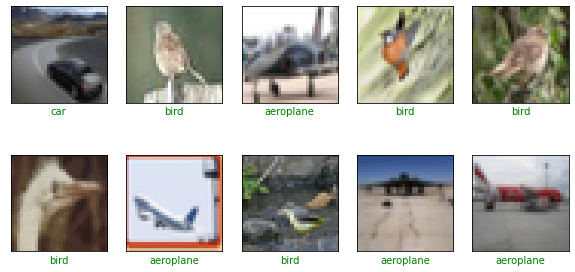

In [ ]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

### Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [ ]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

### Create Validation Data Set

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split = train_test_split(train_images
                                                            ,train_labels,test_size=.1,random_state=42,shuffle=True)

### Confirm Datasets {Train, Validation, Test}

In [ ]:
print(train_images_split.shape, valid_images_split.shape, test_images.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


### Rescale Images {Train, Validation, Test}
The images are 32x32 NumPy arrays, with pixel values ranging from 0 to 255.

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [ ]:
train_images_norm = train_images_split/255
valid_images_norm = valid_images_split/255
test_images_norm = test_images/255

#Experiment 1
DNN with 2 layers (no regularization)

## Create the Model

### Build DNN Model

In [ ]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(32, 32, 3)))
model.add(layers.Dense(units=108, activation=tf.nn.relu))
model.add(layers.Dense(units=200, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax, name="output_layer"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 108)               331884    
                                                                 
 dense_1 (Dense)             (None, 200)               21800     
                                                                 
 output_layer (Dense)        (None, 10)                2010      
                                                                 
Total params: 355,694
Trainable params: 355,694
Non-trainable params: 0
_________________________________________________________________


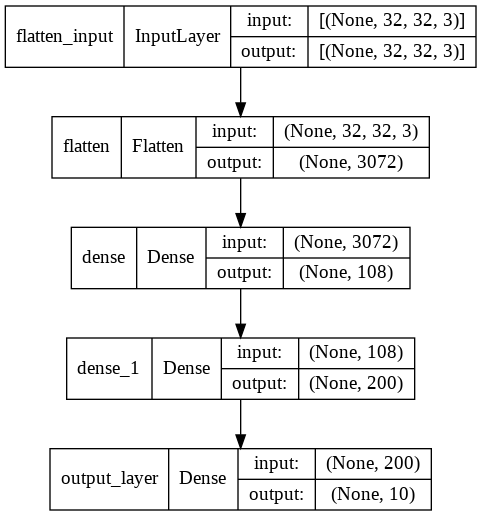

In [ ]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

### Compiling the model

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## Training the model

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
start = time.time()

history = model.fit(train_images_norm
                    ,train_labels_split
                    ,epochs=30
                    ,batch_size=500
                    ,validation_data=(valid_images_norm, valid_labels_split)
                    ,callbacks=[
                    tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/MSDS458/Assignment 2/Models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')] 
                   )

print("Total time: ", time.time() - start, "seconds")

Epoch 1/30
90/90 [==============================] - 3s 10ms/step - loss: 1.9626 - accuracy: 0.2890 - val_loss: 1.8403 - val_accuracy: 0.3468
Epoch 2/30
90/90 [==============================] - 1s 7ms/step - loss: 1.7709 - accuracy: 0.3692 - val_loss: 1.7345 - val_accuracy: 0.3806
Epoch 3/30
90/90 [==============================] - 1s 7ms/step - loss: 1.6898 - accuracy: 0.3982 - val_loss: 1.6875 - val_accuracy: 0.4000
Epoch 4/30
90/90 [==============================] - 1s 7ms/step - loss: 1.6428 - accuracy: 0.4149 - val_loss: 1.6557 - val_accuracy: 0.4014
Epoch 5/30
90/90 [==============================] - 1s 7ms/step - loss: 1.5904 - accuracy: 0.4356 - val_loss: 1.6160 - val_accuracy: 0.4214
Epoch 6/30
90/90 [==============================] - 1s 7ms/step - loss: 1.5609 - accuracy: 0.4495 - val_loss: 1.5862 - val_accuracy: 0.4372
Epoch 7/30
90/90 [==============================] - 1s 6ms/step - loss: 1.5257 - accuracy: 0.4605 - val_loss: 1.5740 - val_accuracy: 0.4338
Epoch 8/30
90/90 [=

## Evaluate the model

In order to ensure that this is not a simple "memorization" by the machine, evaluate the performance on the test set. 

In [ ]:
loss, accuracy = model.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy)

313/313 [==============================] - 2s 6ms/step - loss: 1.3799 - accuracy: 0.5114
test set accuracy:  0.5113999843597412


## Plotting Performance Metrics 

Matplotlib is used to create 2 plots -- displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

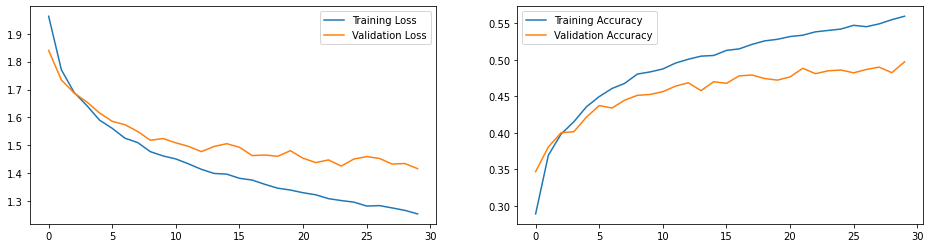

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Confusion matrices
Using `sklearn.metrics`, visualize the confusion matrix.

In [ ]:
pred1= model.predict(test_images_norm)
pred1 = np.argmax(pred1, axis=1)

In [ ]:
conf_mx = confusion_matrix(test_labels, pred1)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

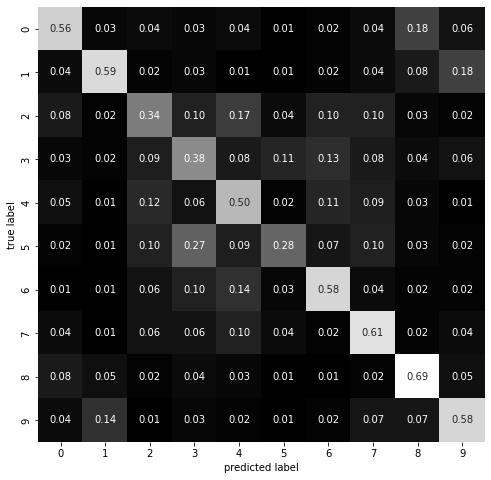

In [ ]:
plot_confusion_matrix(norm_conf_mx)

## Predictions

### Load HDF5 Model Format 

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/MSDS458/Assignment 2/Models/model_0.4970.h5')

In [ ]:
preds = model.predict(test_images_norm)
preds.shape

(10000, 10)

### Visualize predictions

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm) 

##Plot TSNE plot

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(valid_images_norm[:5000])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 1.386s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 3.151020
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.975967
[t-SNE] KL divergence after 300 iterations: 2.933155


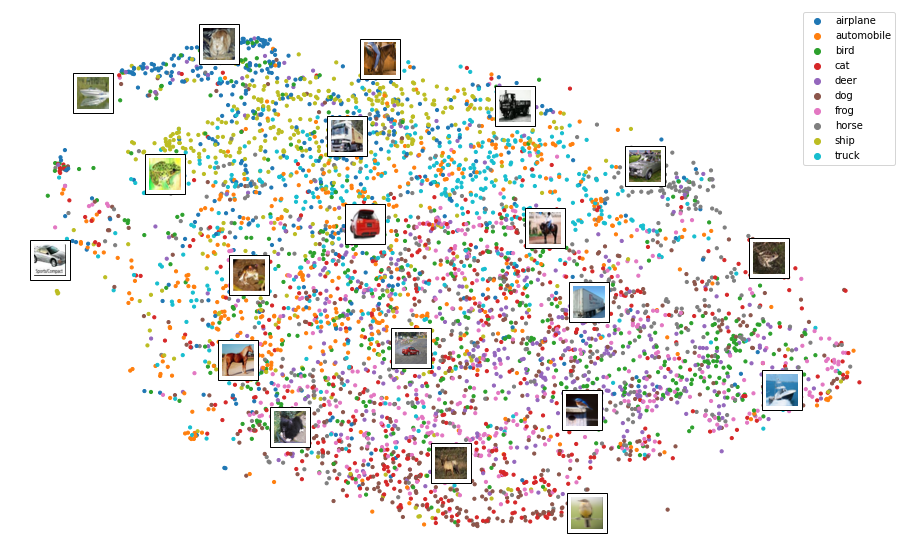

In [ ]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=valid_labels_split[:5000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(train_images[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

#Experiment 2
DNN with 3 layers (no regularization)

## Create the Model

### Build DNN Model

In [ ]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(32, 32, 3)))
model.add(layers.Dense(units=108, activation=tf.nn.relu))
model.add(layers.Dense(units=200, activation=tf.nn.relu))
model.add(layers.Dense(units=282, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax, name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 108)               331884    
                                                                 
 dense_3 (Dense)             (None, 200)               21800     
                                                                 
 dense_4 (Dense)             (None, 282)               56682     
                                                                 
 output_layer (Dense)        (None, 10)                2830      
                                                                 
Total params: 413,196
Trainable params: 413,196
Non-trainable params: 0
_________________________________________________________________


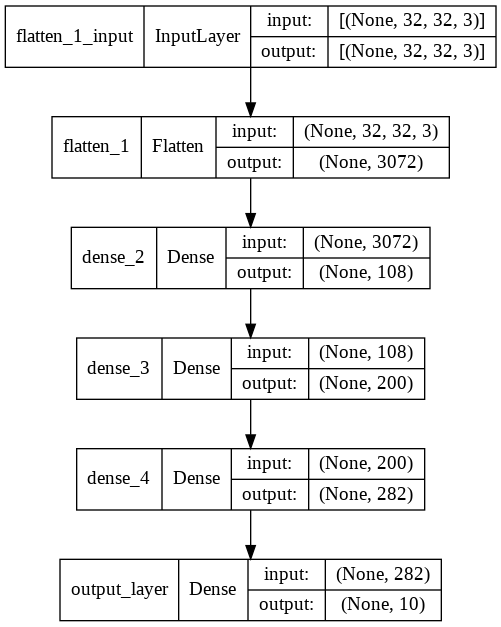

In [ ]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

### Compiling the model

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## Training the model

In [ ]:
start = time.time()

history = model.fit(train_images_norm
                    ,train_labels_split
                    ,epochs=30
                    ,batch_size=500
                    ,validation_data=(valid_images_norm, valid_labels_split)
                   )

print("Total time: ", time.time() - start, "seconds")

Epoch 1/30
90/90 [==============================] - 1s 9ms/step - loss: 1.9474 - accuracy: 0.2896 - val_loss: 1.7923 - val_accuracy: 0.3358
Epoch 2/30
90/90 [==============================] - 1s 7ms/step - loss: 1.7231 - accuracy: 0.3810 - val_loss: 1.7125 - val_accuracy: 0.3872
Epoch 3/30
90/90 [==============================] - 1s 7ms/step - loss: 1.6288 - accuracy: 0.4189 - val_loss: 1.6509 - val_accuracy: 0.4104
Epoch 4/30
90/90 [==============================] - 1s 7ms/step - loss: 1.5760 - accuracy: 0.4364 - val_loss: 1.5846 - val_accuracy: 0.4300
Epoch 5/30
90/90 [==============================] - 1s 7ms/step - loss: 1.5241 - accuracy: 0.4580 - val_loss: 1.5682 - val_accuracy: 0.4372
Epoch 6/30
90/90 [==============================] - 1s 7ms/step - loss: 1.4947 - accuracy: 0.4691 - val_loss: 1.5314 - val_accuracy: 0.4492
Epoch 7/30
90/90 [==============================] - 1s 7ms/step - loss: 1.4552 - accuracy: 0.4837 - val_loss: 1.5216 - val_accuracy: 0.4500
Epoch 8/30
90/90 [==

## Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 1.3994 - accuracy: 0.5066
test set accuracy:  0.506600022315979


## Plotting Performance Metrics 

Matplotlib is used to create 2 plots -- displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

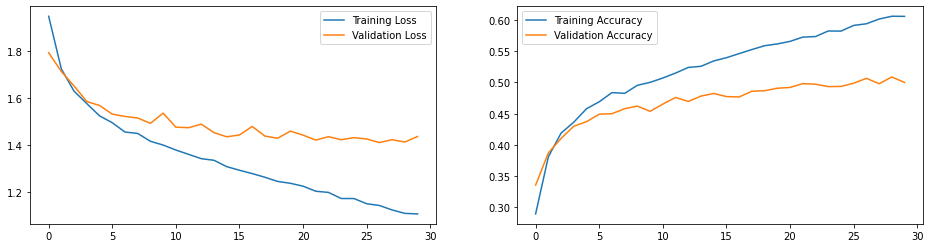

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Confusion matrices
Using `sklearn.metrics`, visualize the confusion matrix.

In [ ]:
pred1= model.predict(test_images_norm)
pred1 = np.argmax(pred1, axis=1)

In [ ]:
conf_mx = confusion_matrix(test_labels, pred1)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

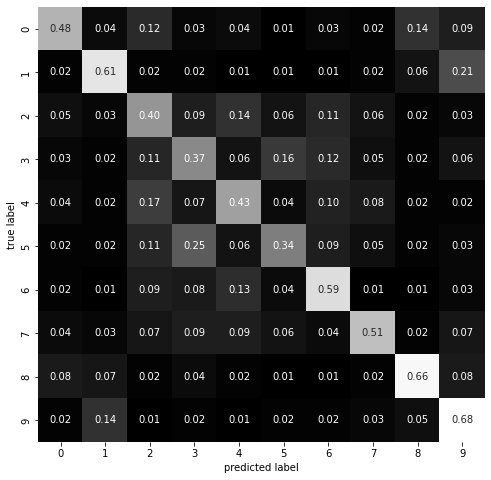

In [ ]:
plot_confusion_matrix(norm_conf_mx)

## Visualize predictions

In [ ]:
preds = model.predict(test_images_norm)
preds.shape

(10000, 10)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm) 

##Plot TSNE plot

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(valid_images_norm[:5000])
dense_layer_activations = activations[-4]
output_layer_activations = activations[-1]

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.650s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 3.090226
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.743637
[t-SNE] KL divergence after 300 iterations: 2.916745


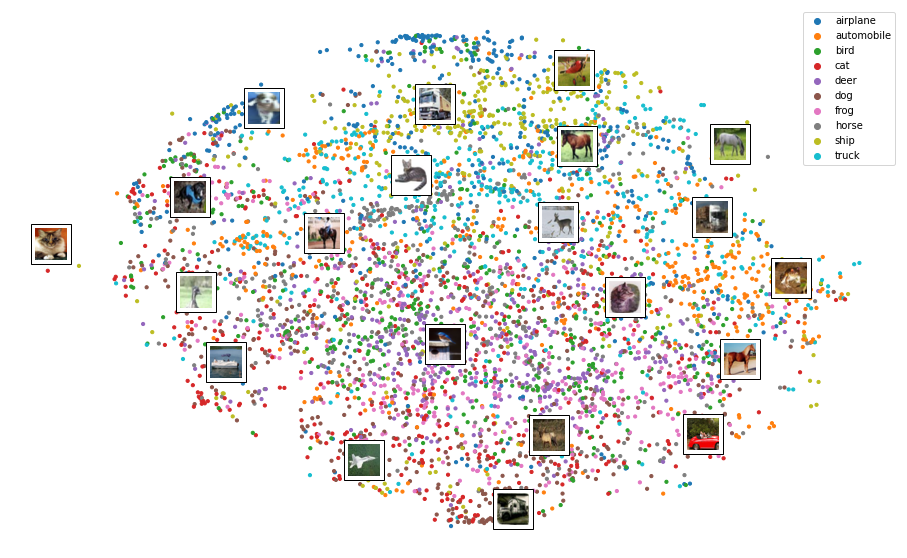

In [ ]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=valid_labels_split[:5000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(train_images[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

#Experiment 3
CNN with 2 convolution/max pooling layers (no regularization)

## Create the Model

### Build CNN Model

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3))) 
model.add(layers.MaxPool2D((2, 2),strides=2))

model.add(layers.Conv2D(filters=108, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))

model.add(layers.Flatten())
model.add(layers.Dense(units=210, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax, name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 108)       62316     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 108)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 3888)              0         
                                                                 
 dense_5 (Dense)             (None, 210)              

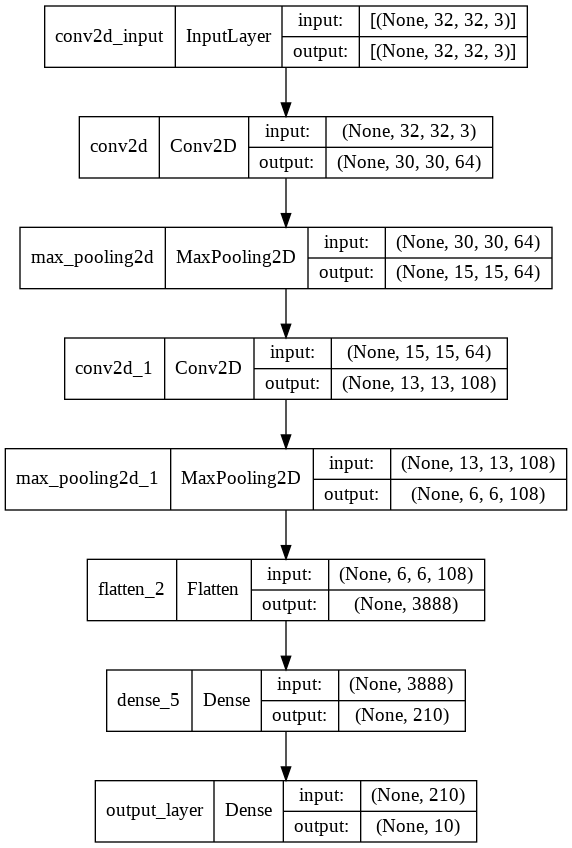

In [ ]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

### Compiling the model

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## Training the model

In [ ]:
start = time.time()

history = model.fit(train_images_norm
                    ,train_labels_split
                    ,epochs=30
                    ,batch_size=500
                    ,validation_data=(valid_images_norm, valid_labels_split)
                   )

print("Total time: ", time.time() - start, "seconds")

Epoch 1/30
90/90 [==============================] - 10s 27ms/step - loss: 1.7183 - accuracy: 0.3798 - val_loss: 1.4817 - val_accuracy: 0.4746
Epoch 2/30
90/90 [==============================] - 2s 24ms/step - loss: 1.3625 - accuracy: 0.5171 - val_loss: 1.2913 - val_accuracy: 0.5390
Epoch 3/30
90/90 [==============================] - 2s 24ms/step - loss: 1.2227 - accuracy: 0.5702 - val_loss: 1.2314 - val_accuracy: 0.5656
Epoch 4/30
90/90 [==============================] - 2s 24ms/step - loss: 1.1300 - accuracy: 0.6058 - val_loss: 1.1198 - val_accuracy: 0.6054
Epoch 5/30
90/90 [==============================] - 2s 24ms/step - loss: 1.0657 - accuracy: 0.6270 - val_loss: 1.0840 - val_accuracy: 0.6206
Epoch 6/30
90/90 [==============================] - 2s 24ms/step - loss: 1.0062 - accuracy: 0.6492 - val_loss: 1.0592 - val_accuracy: 0.6248
Epoch 7/30
90/90 [==============================] - 2s 24ms/step - loss: 0.9639 - accuracy: 0.6669 - val_loss: 0.9939 - val_accuracy: 0.6466
Epoch 8/30
9

## Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy)

313/313 [==============================] - 1s 4ms/step - loss: 1.1319 - accuracy: 0.7033
test set accuracy:  0.7032999992370605


## Plotting Performance Metrics 

Matplotlib is used to create 2 plots -- displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

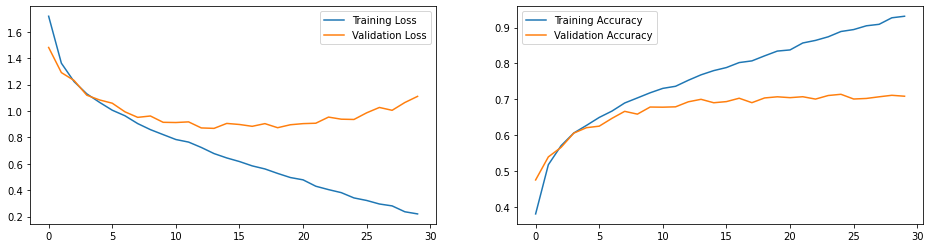

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Confusion matrices
Using `sklearn.metrics`, visualize the confusion matrix.

In [ ]:
pred1= model.predict(test_images_norm)
pred1 = np.argmax(pred1, axis=1)

In [ ]:
conf_mx = confusion_matrix(test_labels, pred1)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

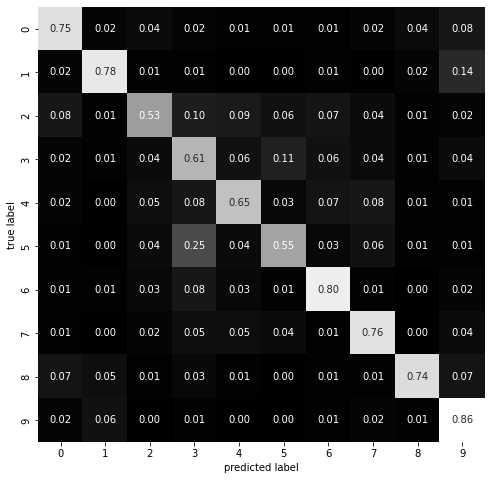

In [ ]:
plot_confusion_matrix(norm_conf_mx)

## Visualize predictions

In [ ]:
preds = model.predict(test_images_norm)
preds.shape

(10000, 10)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm) 

## Plot feature map

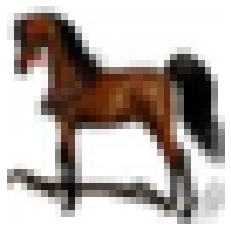

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)

7

In [ ]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten_2',
 'dense_5',
 'output_layer']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


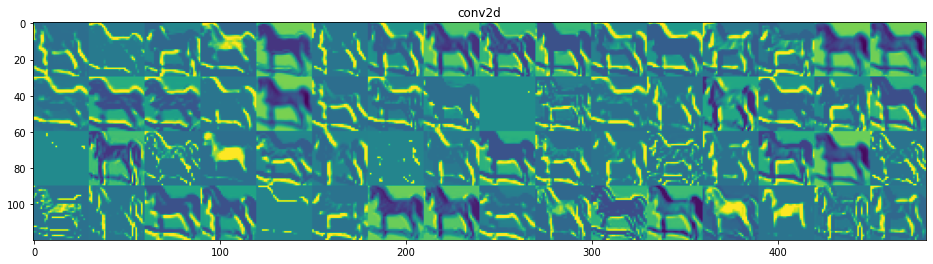

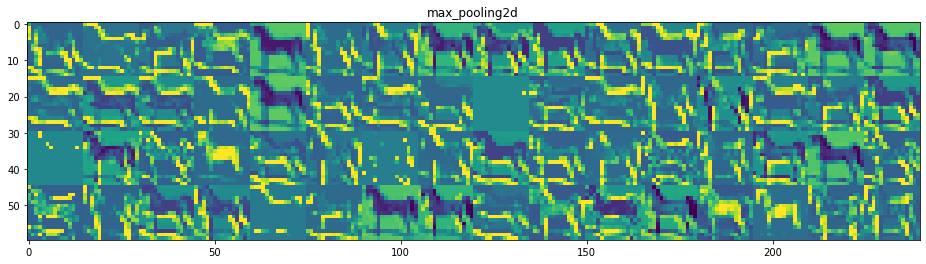

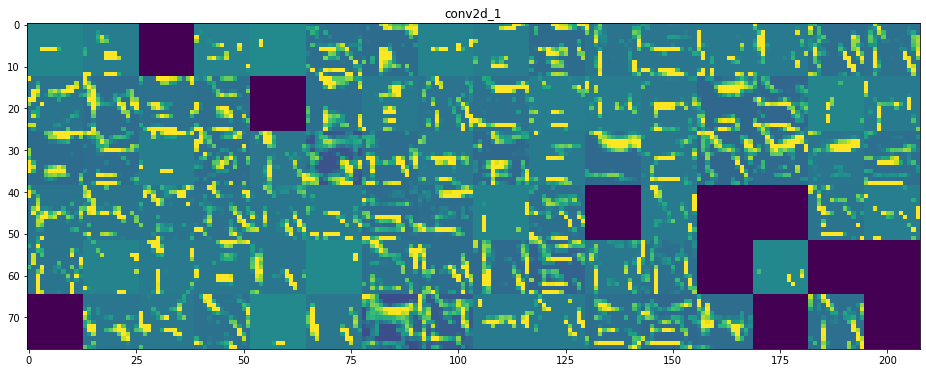

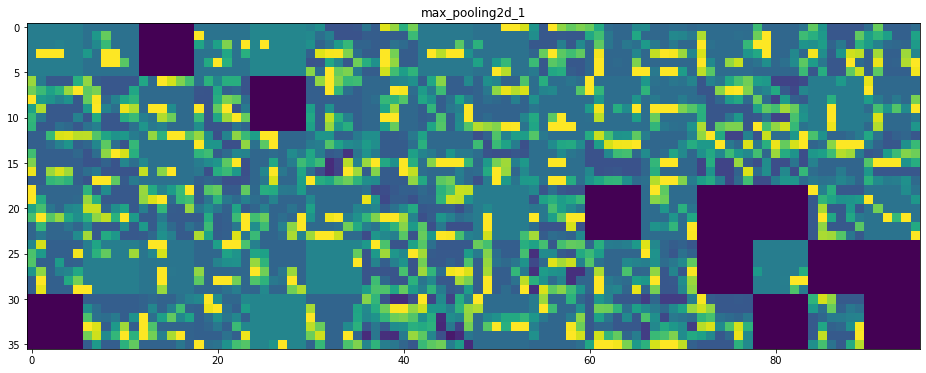

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

##Plot TSNE plot

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(valid_images_norm[:5000])
dense_layer_activations = activations[-2]
output_layer_activations = activations[-1]

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 1.016s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 4.432542
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.325729
[t-SNE] KL divergence after 300 iterations: 2.875303


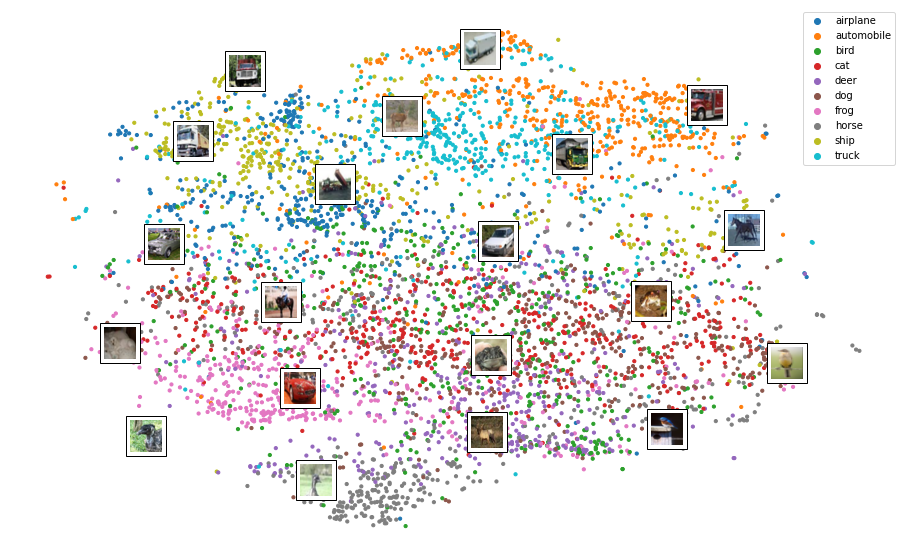

In [ ]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=valid_labels_split[:5000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(train_images[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

#Experiment 4
CNN with 3 convolution/max pooling layers (no regularization)

## Create the Model

### Build CNN Model

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3))) 
model.add(layers.MaxPool2D((2, 2),strides=2))

model.add(layers.Conv2D(filters=108, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))

model.add(layers.Conv2D(filters=180, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))

model.add(layers.Flatten())
model.add(layers.Dense(units=210, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax, name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 108)       62316     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 108)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 180)         175140    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 180)       

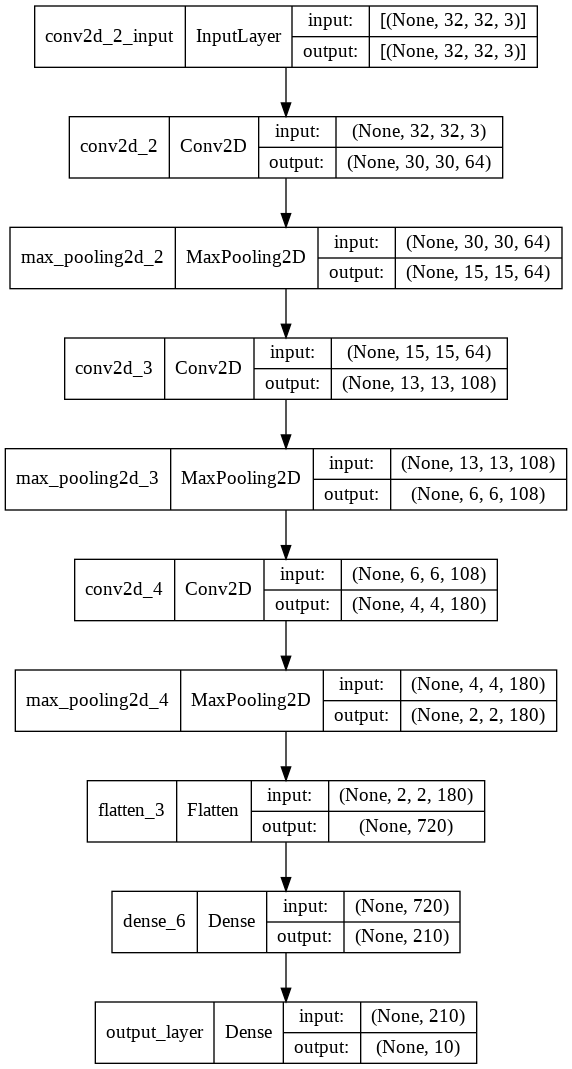

In [ ]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

### Compiling the model

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## Training the model

In [ ]:
start = time.time()

history = model.fit(train_images_norm
                    ,train_labels_split
                    ,epochs=30
                    ,batch_size=500
                    ,validation_data=(valid_images_norm, valid_labels_split)
                   )

print("Total time: ", time.time() - start, "seconds")

Epoch 1/30
90/90 [==============================] - 3s 30ms/step - loss: 1.8360 - accuracy: 0.3301 - val_loss: 1.5425 - val_accuracy: 0.4400
Epoch 2/30
90/90 [==============================] - 2s 27ms/step - loss: 1.4617 - accuracy: 0.4724 - val_loss: 1.3545 - val_accuracy: 0.5178
Epoch 3/30
90/90 [==============================] - 2s 27ms/step - loss: 1.2996 - accuracy: 0.5355 - val_loss: 1.2411 - val_accuracy: 0.5546
Epoch 4/30
90/90 [==============================] - 2s 26ms/step - loss: 1.1961 - accuracy: 0.5773 - val_loss: 1.2051 - val_accuracy: 0.5722
Epoch 5/30
90/90 [==============================] - 2s 27ms/step - loss: 1.1145 - accuracy: 0.6134 - val_loss: 1.0866 - val_accuracy: 0.6126
Epoch 6/30
90/90 [==============================] - 2s 27ms/step - loss: 1.0394 - accuracy: 0.6394 - val_loss: 1.0479 - val_accuracy: 0.6284
Epoch 7/30
90/90 [==============================] - 2s 27ms/step - loss: 0.9886 - accuracy: 0.6578 - val_loss: 1.0262 - val_accuracy: 0.6324
Epoch 8/30
90

## Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy)

313/313 [==============================] - 1s 4ms/step - loss: 0.9989 - accuracy: 0.7161
test set accuracy:  0.7160999774932861


## Plotting Performance Metrics 

Matplotlib is used to create 2 plots -- displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

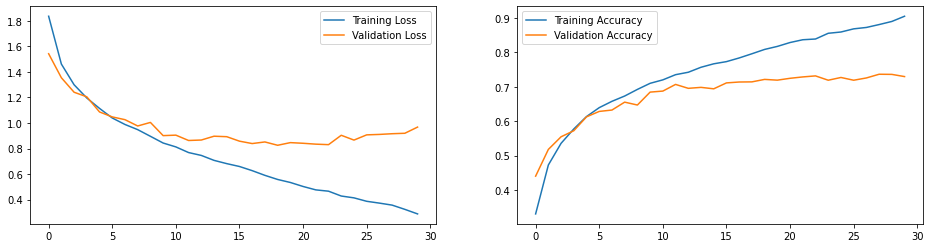

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Confusion matrices
Using `sklearn.metrics`, visualize the confusion matrix.

In [ ]:
pred1= model.predict(test_images_norm)
pred1 = np.argmax(pred1, axis=1)

In [ ]:
conf_mx = confusion_matrix(test_labels, pred1)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

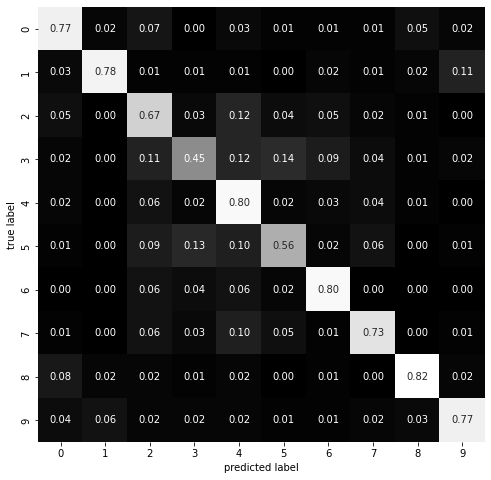

In [ ]:
plot_confusion_matrix(norm_conf_mx)

## Visualize predictions

In [ ]:
preds = model.predict(test_images_norm)
preds.shape

(10000, 10)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm) 

## Plot feature map

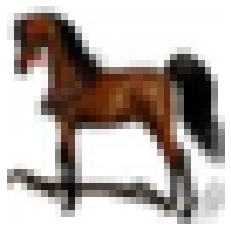

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)

8

In [ ]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d_2',
 'max_pooling2d_2',
 'conv2d_3',
 'max_pooling2d_3',
 'conv2d_4',
 'max_pooling2d_4',
 'flatten_3',
 'dense_6',
 'output_layer']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


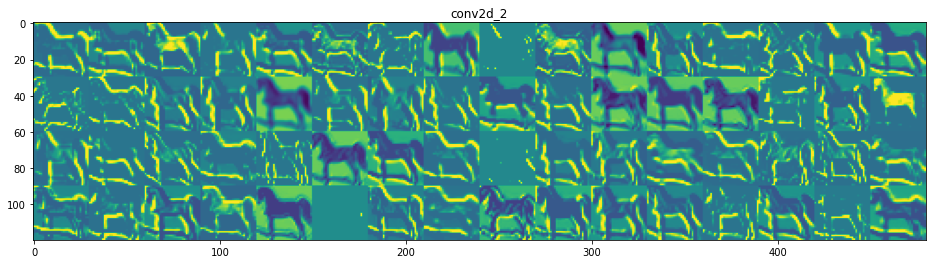

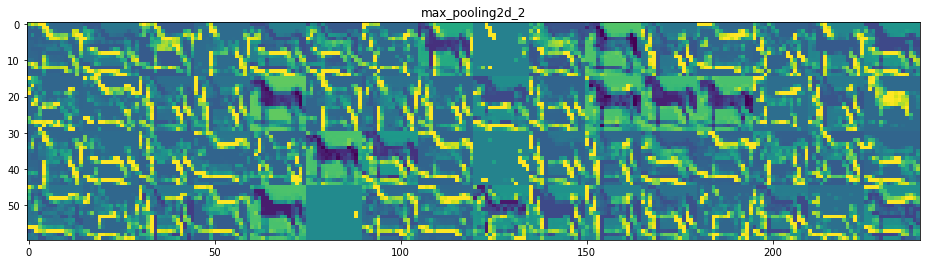

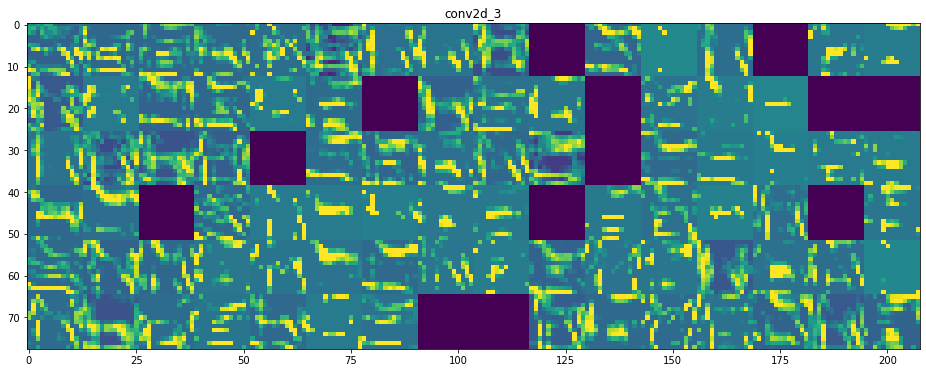

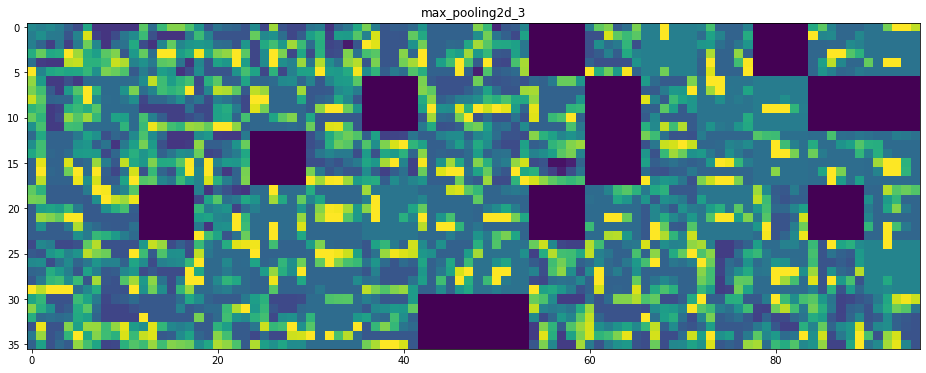

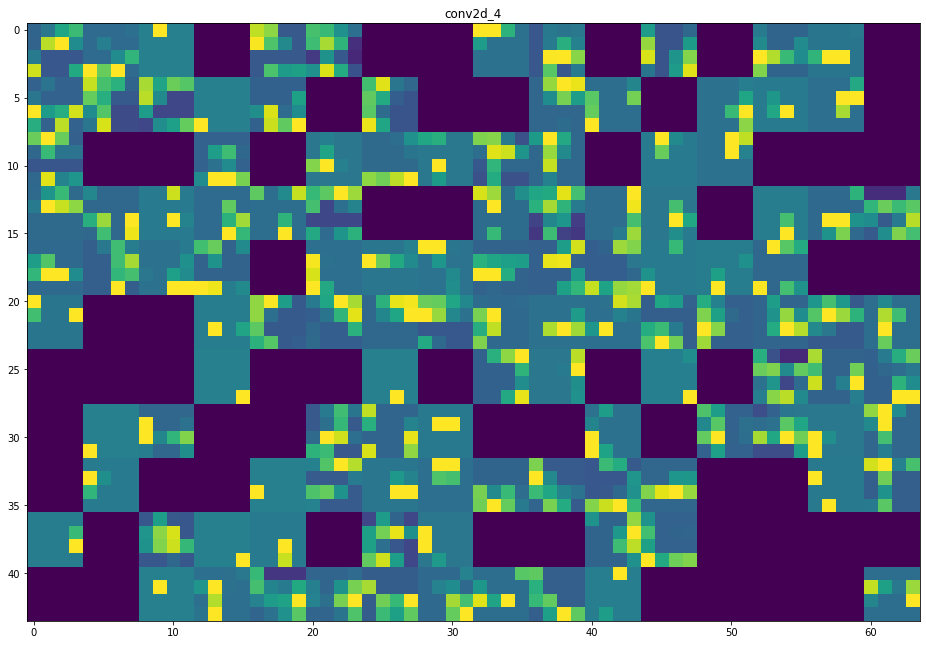

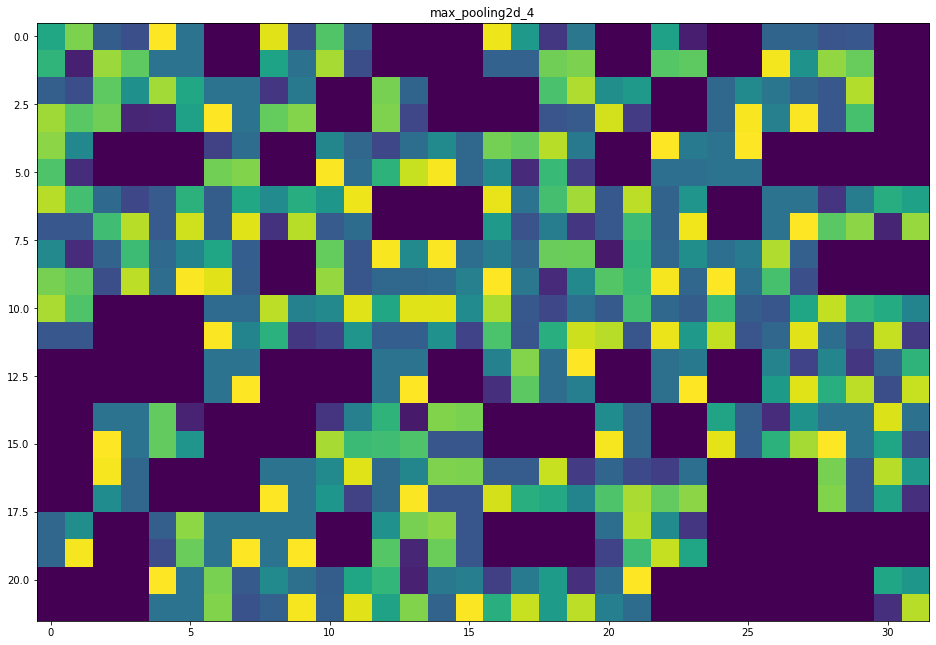

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:6]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

##Plot TSNE plot

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(valid_images_norm[:5000])
dense_layer_activations = activations[-2]
output_layer_activations = activations[-1]

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 1.054s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 3.150424
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.564735
[t-SNE] KL divergence after 300 iterations: 2.680486


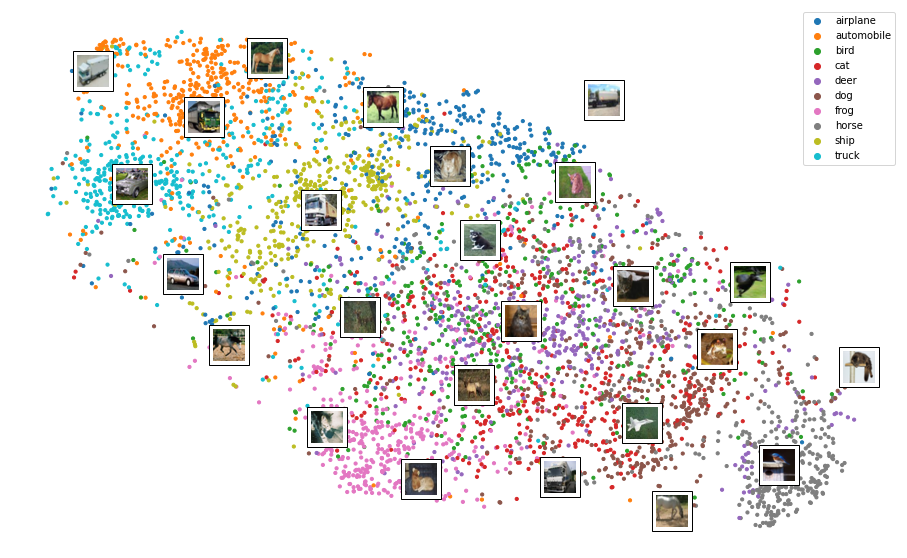

In [ ]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=valid_labels_split[:5000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(train_images[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

#Experiment 5
DNN with 2 layers with regularization (batch normalization, dropout, early stopping)

## Create the Model

### Build DNN Model

In [ ]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())

model.add(layers.Dense(units=108, activation=tf.nn.relu))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=200, activation=tf.nn.relu))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=10, activation=tf.nn.softmax, name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 3072)              0         
                                                                 
 batch_normalization (BatchN  (None, 3072)             12288     
 ormalization)                                                   
                                                                 
 dense_7 (Dense)             (None, 108)               331884    
                                                                 
 dropout (Dropout)           (None, 108)               0         
                                                                 
 dense_8 (Dense)             (None, 200)               21800     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                      

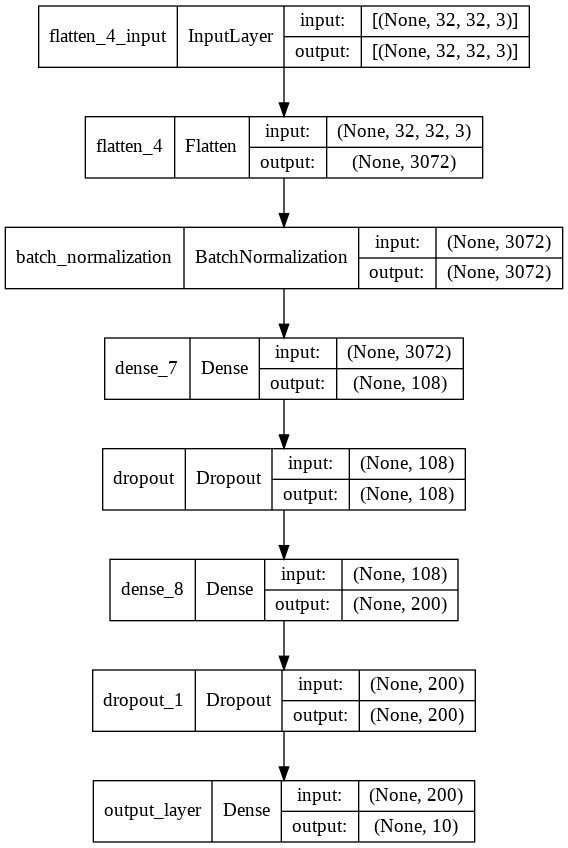

In [ ]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

### Compiling the model

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## Training the model

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
start = time.time()

history = model.fit(train_images_norm
                    ,train_labels_split
                    ,epochs=30
                    ,batch_size=500
                    ,validation_data=(valid_images_norm, valid_labels_split)
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)],
                   )

print("Total time: ", time.time() - start, "seconds")

Epoch 1/30
90/90 [==============================] - 1s 10ms/step - loss: 1.9901 - accuracy: 0.3066 - val_loss: 1.9786 - val_accuracy: 0.3528
Epoch 2/30
90/90 [==============================] - 1s 7ms/step - loss: 1.7454 - accuracy: 0.3816 - val_loss: 1.8003 - val_accuracy: 0.4198
Epoch 3/30
90/90 [==============================] - 1s 8ms/step - loss: 1.6634 - accuracy: 0.4111 - val_loss: 1.6665 - val_accuracy: 0.4446
Epoch 4/30
90/90 [==============================] - 1s 8ms/step - loss: 1.6043 - accuracy: 0.4295 - val_loss: 1.5723 - val_accuracy: 0.4642
Epoch 5/30
90/90 [==============================] - 1s 8ms/step - loss: 1.5664 - accuracy: 0.4463 - val_loss: 1.5152 - val_accuracy: 0.4590
Epoch 6/30
90/90 [==============================] - 1s 7ms/step - loss: 1.5296 - accuracy: 0.4566 - val_loss: 1.4934 - val_accuracy: 0.4684
Epoch 7/30
90/90 [==============================] - 1s 7ms/step - loss: 1.4920 - accuracy: 0.4709 - val_loss: 1.4603 - val_accuracy: 0.4808
Epoch 8/30
90/90 [=

## Evaluate the model

In order to ensure that this is not a simple "memorization" by the machine, evaluate the performance on the test set. 

In [ ]:
loss, accuracy = model.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 1.3253 - accuracy: 0.5302
test set accuracy:  0.5302000045776367


## Plotting Performance Metrics 

Matplotlib is used to create 2 plots -- displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

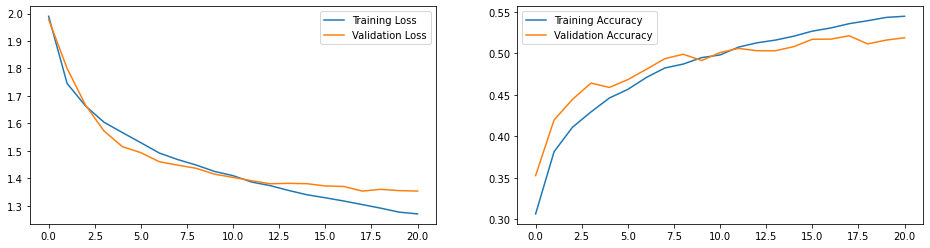

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Confusion matrices
Using `sklearn.metrics`, visualize the confusion matrix.

In [ ]:
pred1= model.predict(test_images_norm)
pred1 = np.argmax(pred1, axis=1)

In [ ]:
conf_mx = confusion_matrix(test_labels, pred1)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

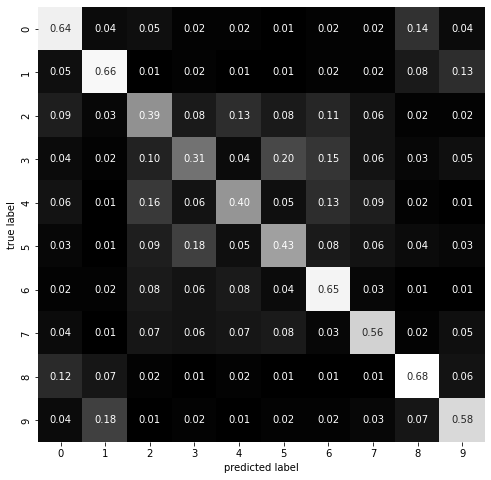

In [ ]:
plot_confusion_matrix(norm_conf_mx)

## Visualize predictions

In [ ]:
preds = model.predict(test_images_norm)
preds.shape

(10000, 10)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm) 

##Plot TSNE plot

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(valid_images_norm[:5000])
dense_layer_activations = activations[-4]
output_layer_activations = activations[-1]

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.726s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 5.067357
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.941147
[t-SNE] KL divergence after 300 iterations: 2.856572


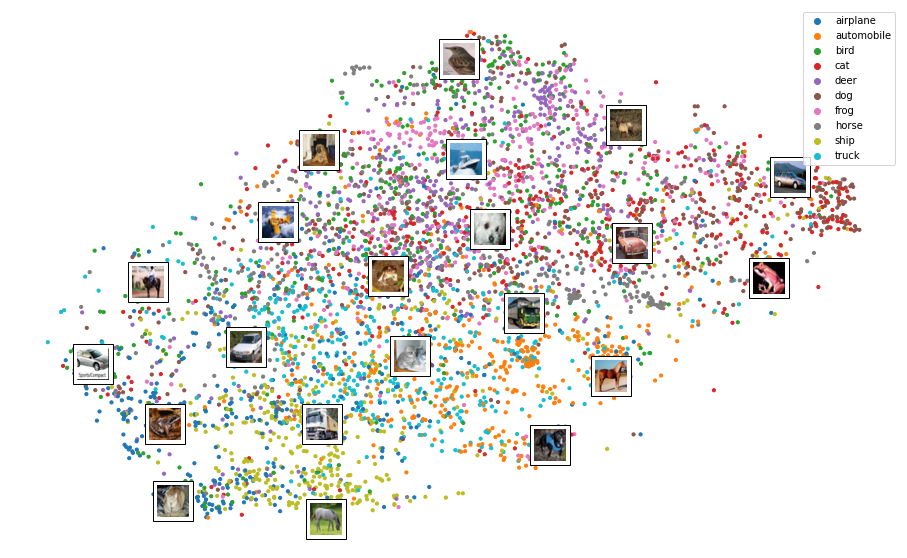

In [ ]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=valid_labels_split[:5000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(train_images[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

#Experiment 6
DNN with 3 layers with regularization (batch normalization, L2 regulariazation, dropout, early stopping)

## Create the Model

### Build DNN Model

In [ ]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())

model.add(layers.Dense(units=108, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=200, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=282, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=10, activation=tf.nn.softmax, name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 3072)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 3072)             12288     
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 108)               331884    
                                                                 
 dropout_2 (Dropout)         (None, 108)               0         
                                                                 
 dense_10 (Dense)            (None, 200)               21800     
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                      

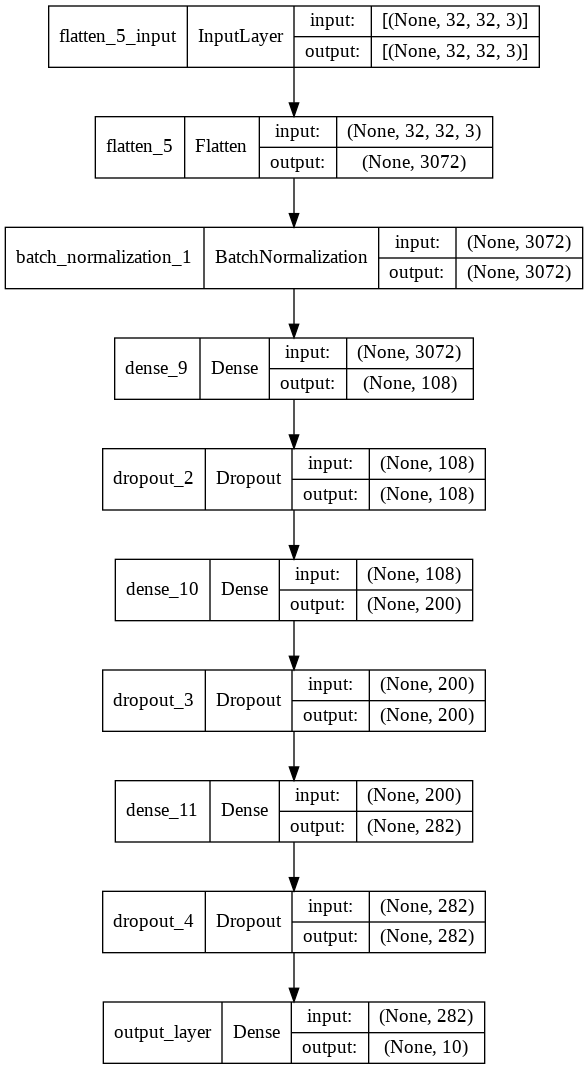

In [ ]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

### Compiling the model

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## Training the model

In [ ]:
start = time.time()

history = model.fit(train_images_norm
                    ,train_labels_split
                    ,epochs=30
                    ,batch_size=500
                    ,validation_data=(valid_images_norm, valid_labels_split)
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)],
                   )

print("Total time: ", time.time() - start, "seconds")

Epoch 1/30
90/90 [==============================] - 2s 19ms/step - loss: 2.5250 - accuracy: 0.2909 - val_loss: 2.5056 - val_accuracy: 0.3684
Epoch 2/30
90/90 [==============================] - 1s 12ms/step - loss: 2.2334 - accuracy: 0.3690 - val_loss: 2.2489 - val_accuracy: 0.4150
Epoch 3/30
90/90 [==============================] - 1s 12ms/step - loss: 2.0843 - accuracy: 0.4002 - val_loss: 2.0301 - val_accuracy: 0.4452
Epoch 4/30
90/90 [==============================] - 1s 8ms/step - loss: 1.9720 - accuracy: 0.4199 - val_loss: 1.9016 - val_accuracy: 0.4654
Epoch 5/30
90/90 [==============================] - 1s 8ms/step - loss: 1.8804 - accuracy: 0.4376 - val_loss: 1.8068 - val_accuracy: 0.4670
Epoch 6/30
90/90 [==============================] - 1s 8ms/step - loss: 1.8153 - accuracy: 0.4446 - val_loss: 1.7397 - val_accuracy: 0.4656
Epoch 7/30
90/90 [==============================] - 1s 8ms/step - loss: 1.7574 - accuracy: 0.4555 - val_loss: 1.6971 - val_accuracy: 0.4840
Epoch 8/30
90/90 

## Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 1.5059 - accuracy: 0.5206
test set accuracy:  0.5206000208854675


## Plotting Performance Metrics 

Matplotlib is used to create 2 plots -- displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

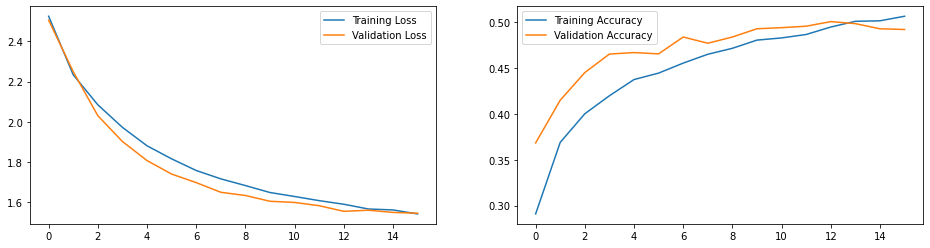

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Confusion matrices
Using `sklearn.metrics`, visualize the confusion matrix.

In [ ]:
pred1= model.predict(test_images_norm)
pred1 = np.argmax(pred1, axis=1)

In [ ]:
conf_mx = confusion_matrix(test_labels, pred1)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

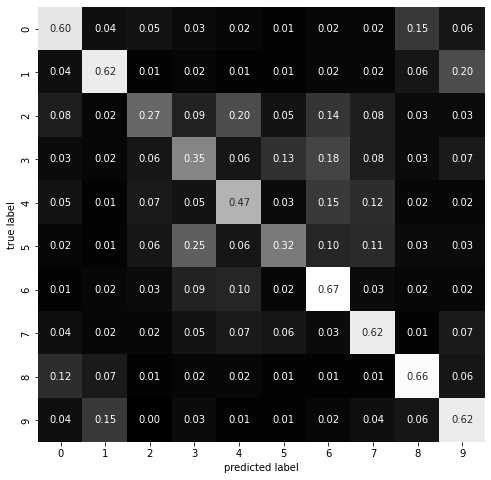

In [ ]:
plot_confusion_matrix(norm_conf_mx)

## Visualize predictions

In [ ]:
preds = model.predict(test_images_norm)
preds.shape

(10000, 10)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm) 

##Plot TSNE plot

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(valid_images_norm[:5000])
dense_layer_activations = activations[-4]
output_layer_activations = activations[-1]

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.799s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.397671
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.499779
[t-SNE] KL divergence after 300 iterations: 2.400108


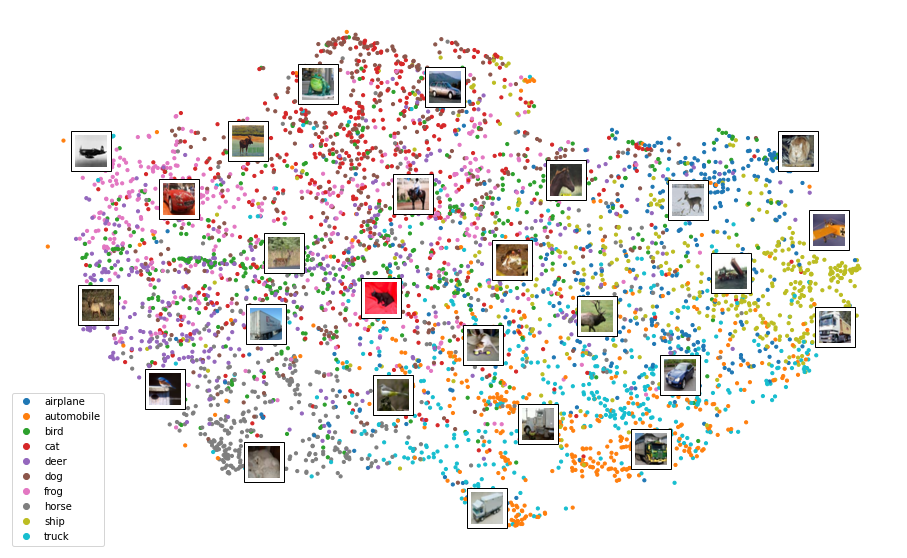

In [ ]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=valid_labels_split[:5000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(train_images[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

#Experiment 7
CNN with 2 convolution/max pooling layers with regularization (L2 regularization, dropout, early stopping)

## Create the Model

### Build CNN Model

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(32, 32, 3)))
model.add(layers.MaxPool2D((2, 2),strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters=108, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(units=210, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(layers.Dense(units=10, activation=tf.nn.softmax, name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 15, 15, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 108)       62316     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 108)        0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 6, 6, 108)        

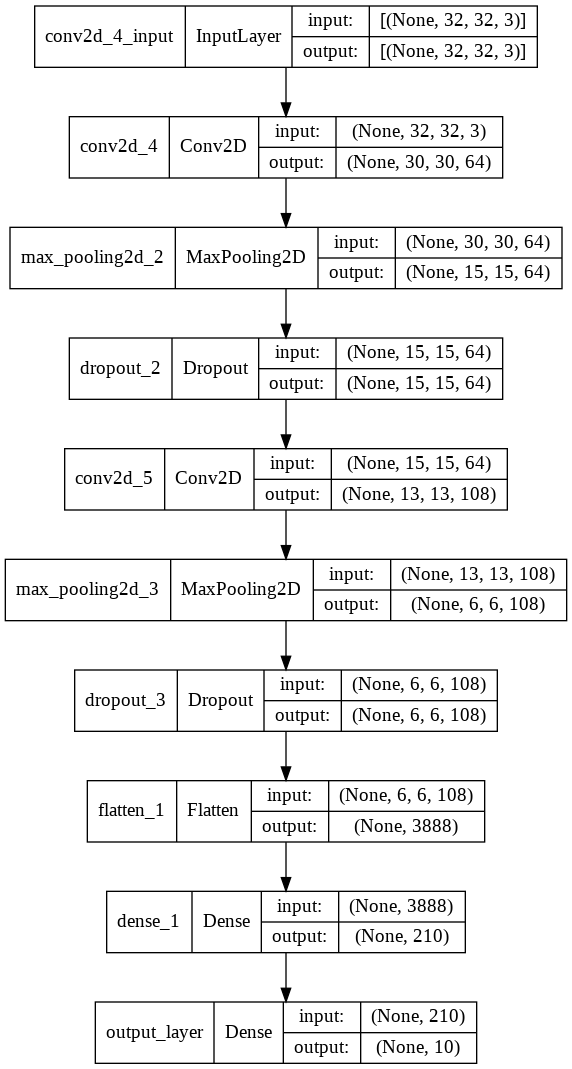

In [ ]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

### Compiling the model

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## Training the model

In [ ]:
start = time.time()

history = model.fit(train_images_norm
                    ,train_labels_split
                    ,epochs=30
                    ,batch_size=500
                    ,validation_data=(valid_images_norm, valid_labels_split)
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)],
                   )

print("Total time: ", time.time() - start, "seconds")

Epoch 1/30
90/90 [==============================] - 2s 17ms/step - loss: 2.0325 - accuracy: 0.3316 - val_loss: 1.6537 - val_accuracy: 0.4438
Epoch 2/30
90/90 [==============================] - 1s 14ms/step - loss: 1.5394 - accuracy: 0.4848 - val_loss: 1.4328 - val_accuracy: 0.5236
Epoch 3/30
90/90 [==============================] - 1s 14ms/step - loss: 1.3914 - accuracy: 0.5408 - val_loss: 1.3557 - val_accuracy: 0.5528
Epoch 4/30
90/90 [==============================] - 1s 14ms/step - loss: 1.2978 - accuracy: 0.5783 - val_loss: 1.2694 - val_accuracy: 0.5896
Epoch 5/30
90/90 [==============================] - 1s 14ms/step - loss: 1.2395 - accuracy: 0.6026 - val_loss: 1.1851 - val_accuracy: 0.6228
Epoch 6/30
90/90 [==============================] - 1s 14ms/step - loss: 1.1817 - accuracy: 0.6219 - val_loss: 1.1573 - val_accuracy: 0.6266
Epoch 7/30
90/90 [==============================] - 1s 14ms/step - loss: 1.1452 - accuracy: 0.6377 - val_loss: 1.1302 - val_accuracy: 0.6410
Epoch 8/30
90

## Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.9364 - accuracy: 0.7325
test set accuracy:  0.7325000166893005


## Plotting Performance Metrics 

Matplotlib is used to create 2 plots -- displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

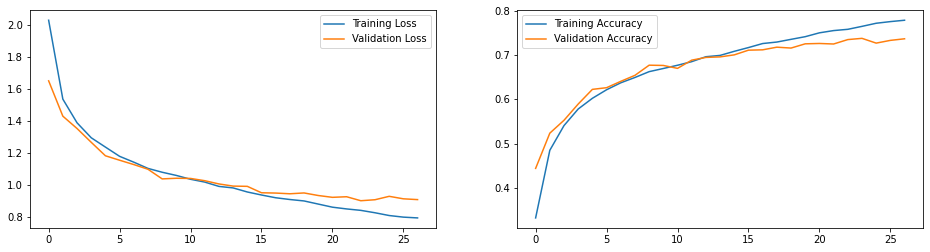

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Confusion matrices
Using `sklearn.metrics`, visualize the confusion matrix.

In [ ]:
pred1= model.predict(test_images_norm)
pred1 = np.argmax(pred1, axis=1)

In [ ]:
conf_mx = confusion_matrix(test_labels, pred1)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

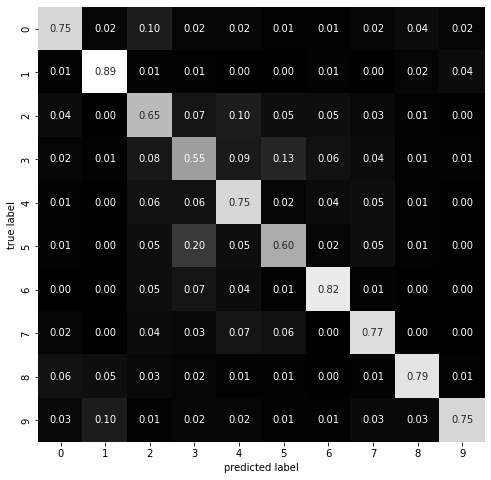

In [ ]:
plot_confusion_matrix(norm_conf_mx)

## Visualize predictions

In [ ]:
preds = model.predict(test_images_norm)
preds.shape

(10000, 10)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm) 

## Plot feature map

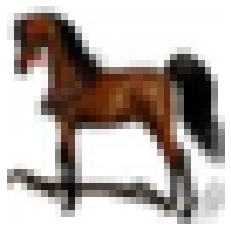

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)

8

In [ ]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d_4',
 'max_pooling2d_2',
 'dropout_2',
 'conv2d_5',
 'max_pooling2d_3',
 'dropout_3',
 'flatten_1',
 'dense_1',
 'output_layer']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


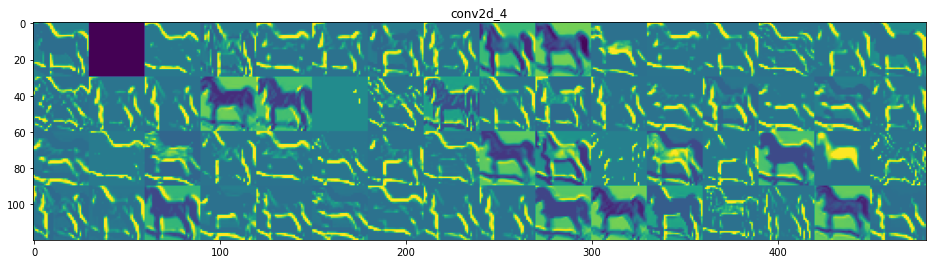

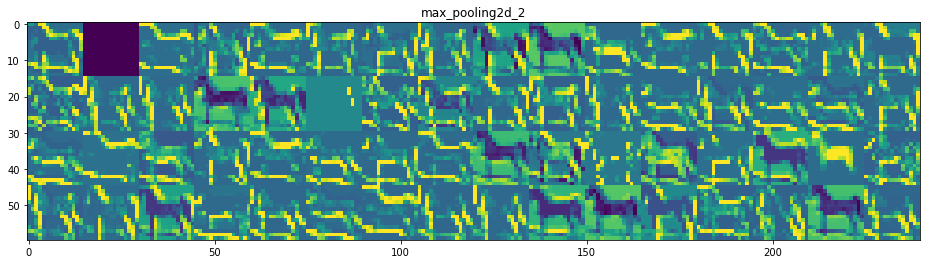

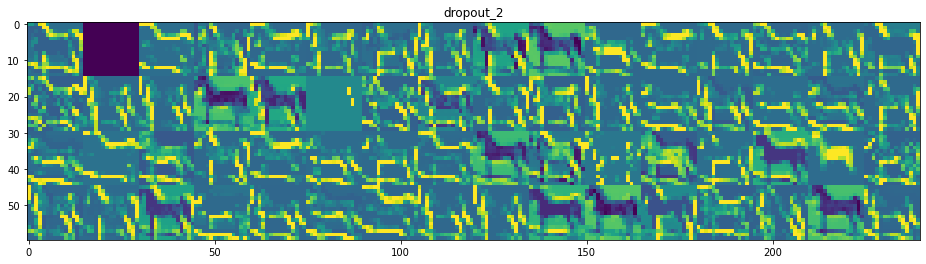

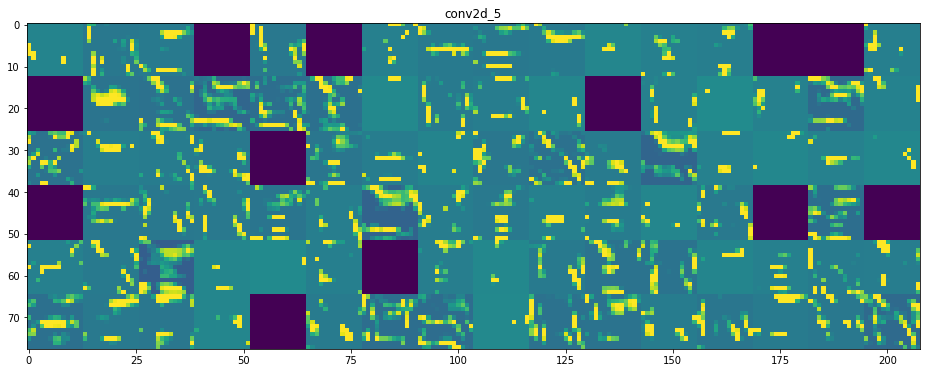

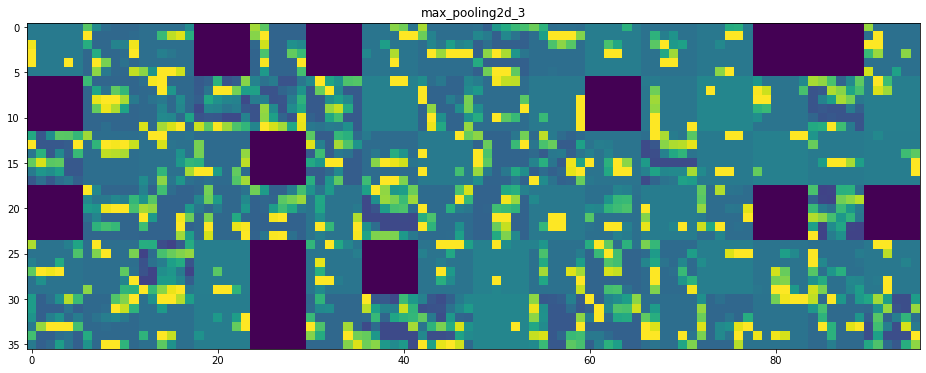

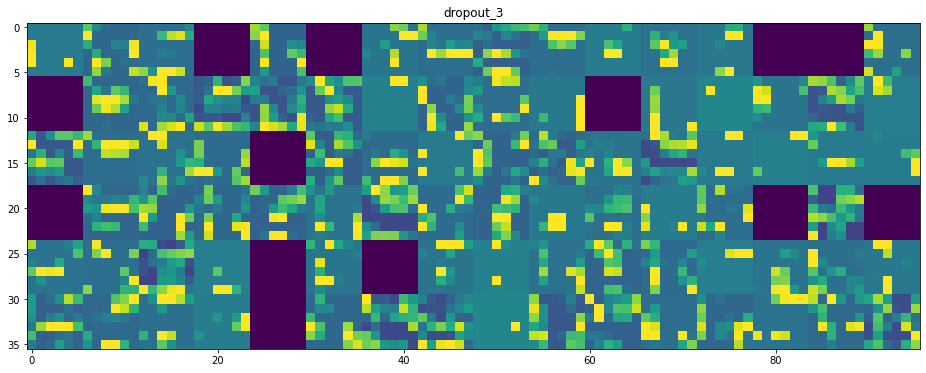

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:6]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

##Plot TSNE plot

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(valid_images_norm[:5000])
dense_layer_activations = activations[-2]
output_layer_activations = activations[-1]

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.664s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.907308
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.949333
[t-SNE] KL divergence after 300 iterations: 2.789860


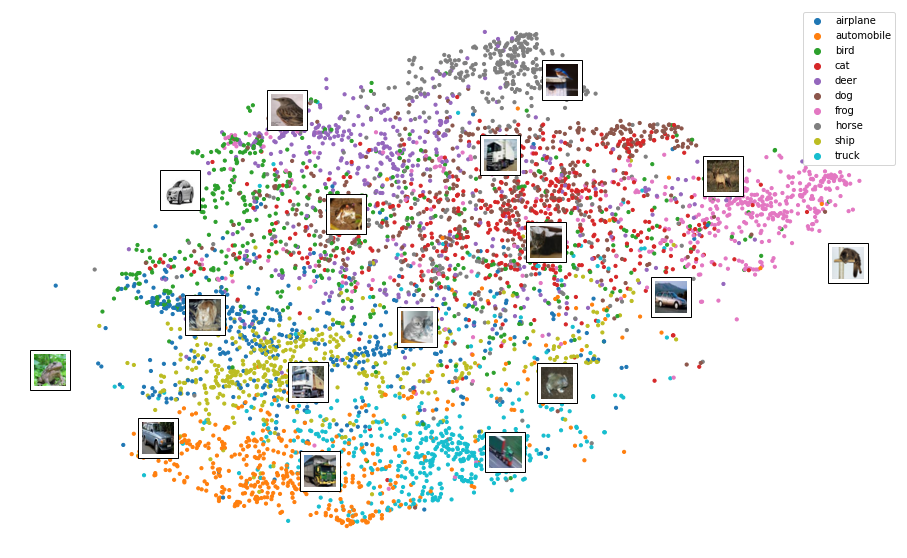

In [ ]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=valid_labels_split[:5000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(train_images[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

#Experiment 8
CNN with 3 convolution/max pooling layers with regularization (L2 regularization, dropout, early stopping)

## Create the Model

### Build CNN Model

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3))) 
model.add(layers.MaxPool2D((2, 2),strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters=108, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters=180, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(units=210, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(layers.Dense(units=10, activation=tf.nn.softmax, name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 15, 15, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 108)       62316     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 108)        0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 6, 6, 108)        

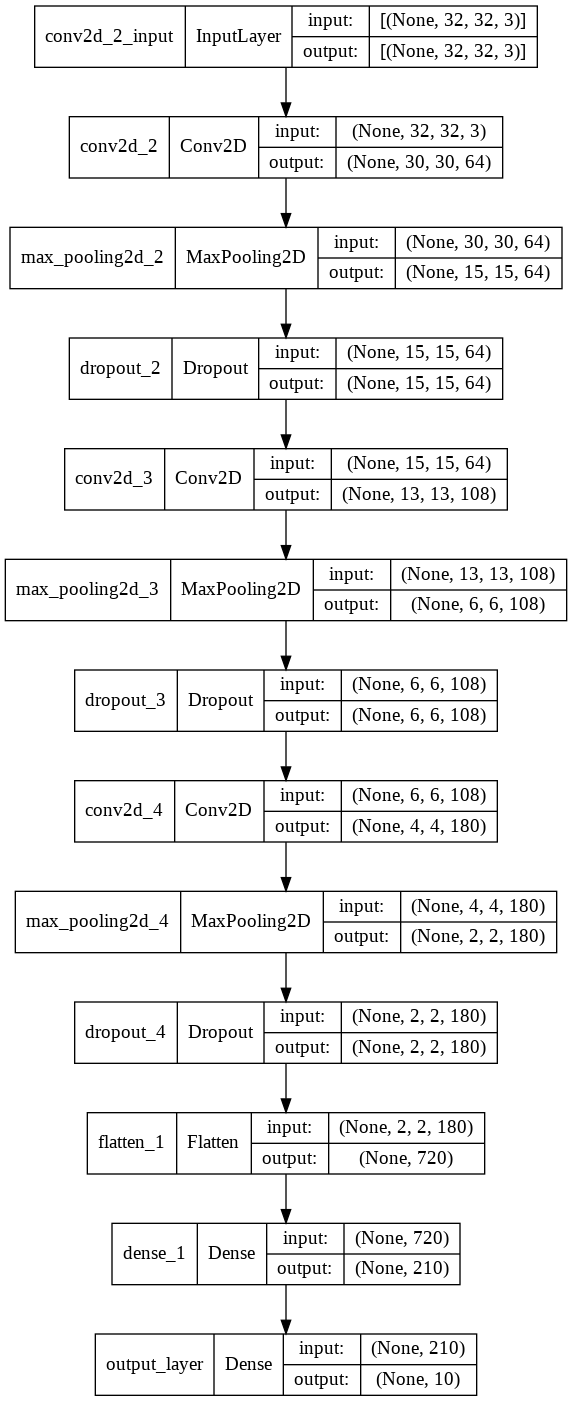

In [ ]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

### Compiling the model

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## Training the model

In [ ]:
start = time.time()

history = model.fit(train_images_norm
                    ,train_labels_split
                    ,epochs=30
                    ,batch_size=500
                    ,validation_data=(valid_images_norm, valid_labels_split)
                   ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)],
                   )

print("Total time: ", time.time() - start, "seconds")

Epoch 1/30
90/90 [==============================] - 4s 31ms/step - loss: 2.1352 - accuracy: 0.2789 - val_loss: 1.8295 - val_accuracy: 0.3756
Epoch 2/30
90/90 [==============================] - 3s 29ms/step - loss: 1.6731 - accuracy: 0.4256 - val_loss: 1.5189 - val_accuracy: 0.4984
Epoch 3/30
90/90 [==============================] - 3s 28ms/step - loss: 1.4918 - accuracy: 0.4921 - val_loss: 1.3718 - val_accuracy: 0.5484
Epoch 4/30
90/90 [==============================] - 3s 28ms/step - loss: 1.3806 - accuracy: 0.5299 - val_loss: 1.2832 - val_accuracy: 0.5688
Epoch 5/30
90/90 [==============================] - 3s 29ms/step - loss: 1.3029 - accuracy: 0.5603 - val_loss: 1.2086 - val_accuracy: 0.6110
Epoch 6/30
90/90 [==============================] - 3s 28ms/step - loss: 1.2357 - accuracy: 0.5874 - val_loss: 1.1215 - val_accuracy: 0.6244
Epoch 7/30
90/90 [==============================] - 3s 29ms/step - loss: 1.1833 - accuracy: 0.6014 - val_loss: 1.0788 - val_accuracy: 0.6394
Epoch 8/30
90

## Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy)

313/313 [==============================] - 1s 4ms/step - loss: 0.7437 - accuracy: 0.7626
test set accuracy:  0.7626000046730042


## Plotting Performance Metrics 

Matplotlib is used to create 2 plots -- displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

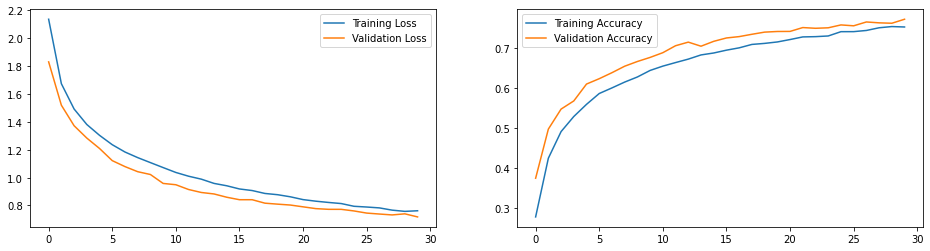

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Confusion matrices
Using `sklearn.metrics`, visualize the confusion matrix.

In [ ]:
pred1= model.predict(test_images_norm)
pred1 = np.argmax(pred1, axis=1)

In [ ]:
conf_mx = confusion_matrix(test_labels, pred1)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

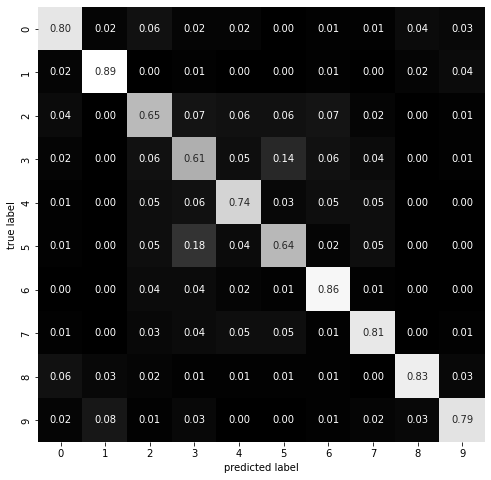

In [ ]:
plot_confusion_matrix(norm_conf_mx)

## Visualize predictions

In [ ]:
preds = model.predict(test_images_norm)
preds.shape

(10000, 10)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm) 

## Plot feature map

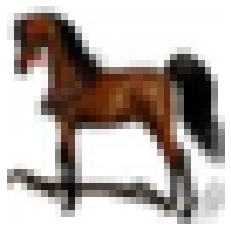

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)

8

In [ ]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d_2',
 'max_pooling2d_2',
 'dropout_2',
 'conv2d_3',
 'max_pooling2d_3',
 'dropout_3',
 'conv2d_4',
 'max_pooling2d_4',
 'dropout_4',
 'flatten_1',
 'dense_1',
 'output_layer']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


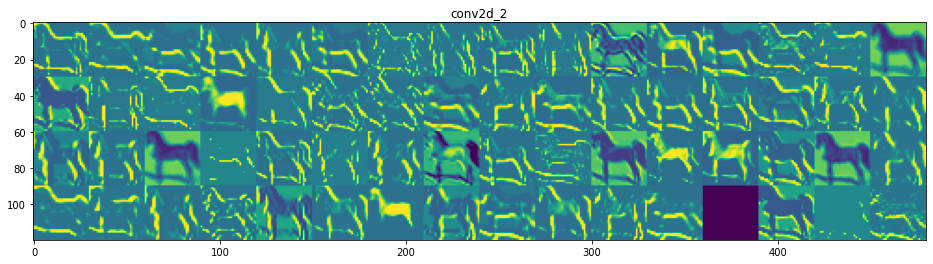

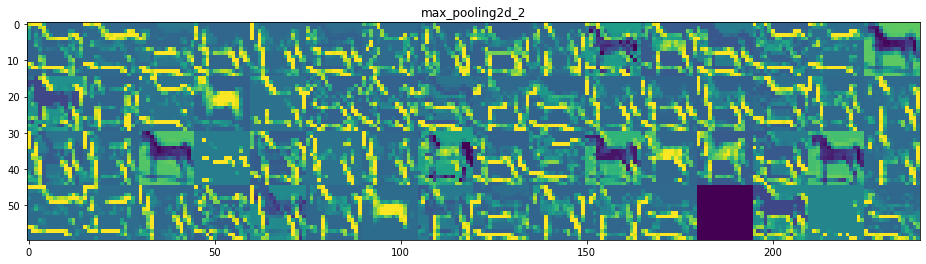

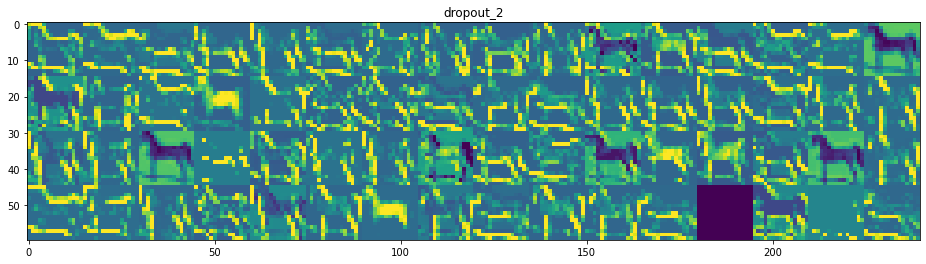

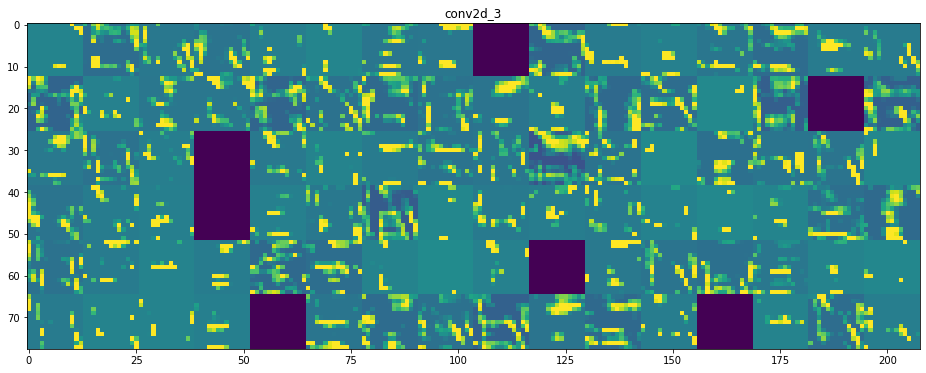

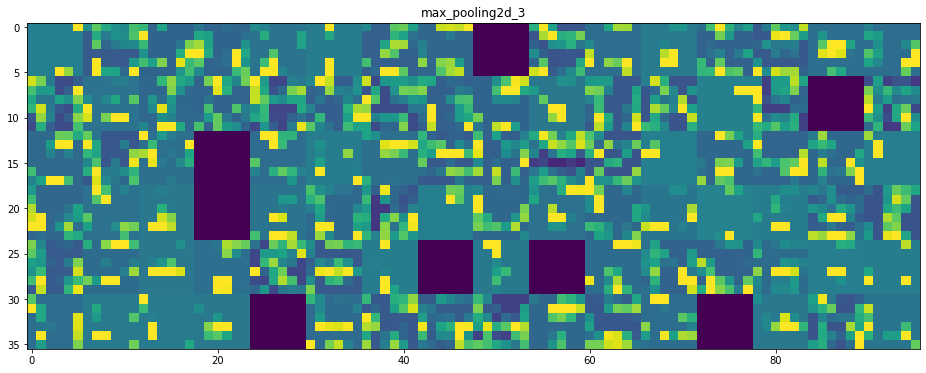

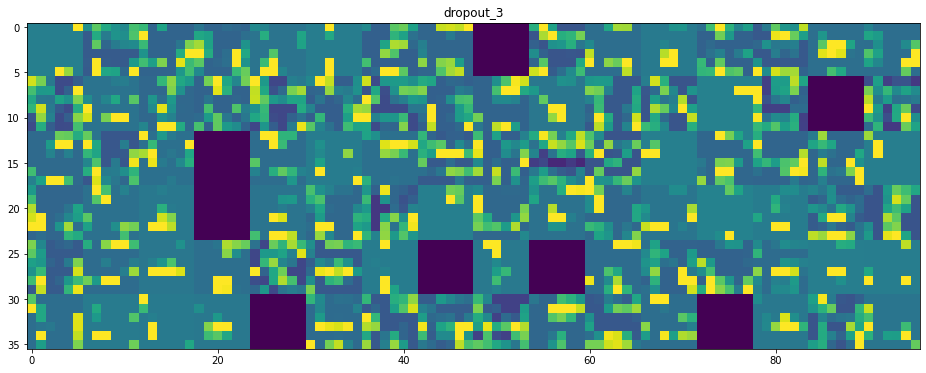

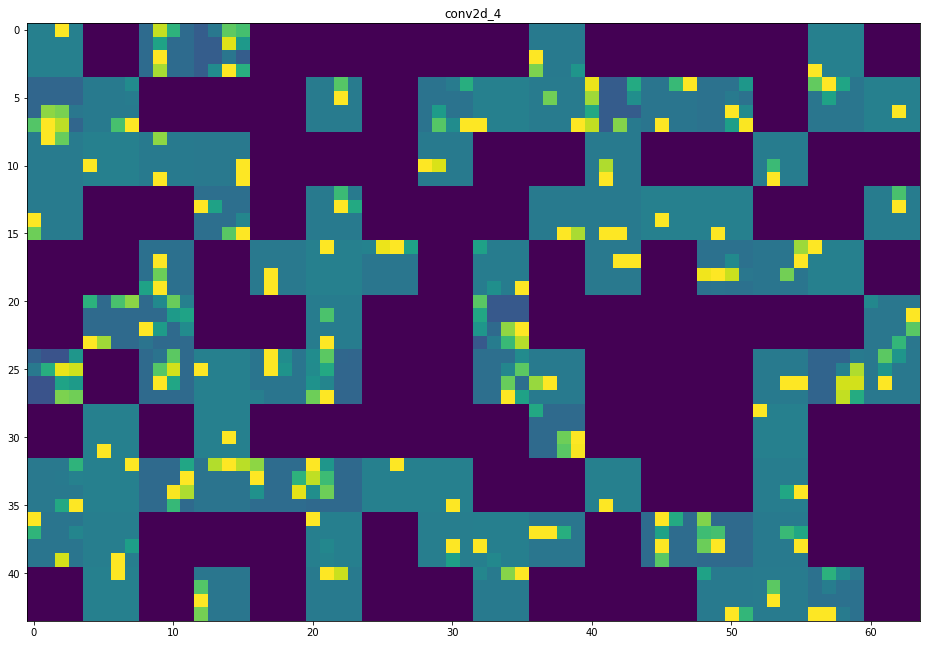

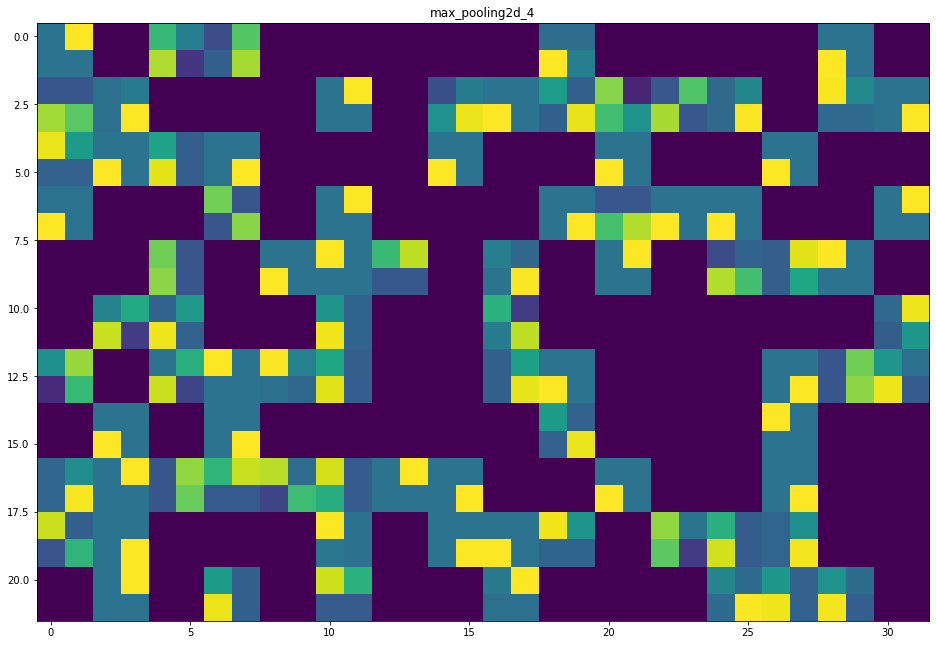

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

##Plot TSNE plot

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(valid_images_norm[:5000])
dense_layer_activations = activations[-2]
output_layer_activations = activations[-1]

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.853s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.917538
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.486435
[t-SNE] KL divergence after 300 iterations: 2.318424


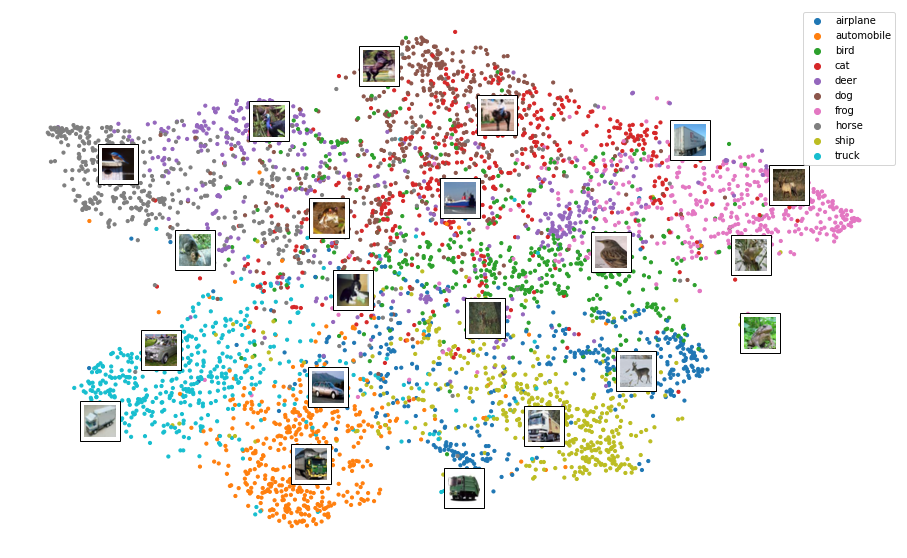

In [ ]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=valid_labels_split[:5000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(train_images[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

#Experiment 9
CNN with 3 convolution/max pooling layers with regularization (L2 regularization, dropout, early stopping) and increased complexity using a larger number of filters, nodes, and epochs than Experiment 8.

## Create the Model

### Build CNN Model

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3))) 
model.add(layers.MaxPool2D((2, 2),strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters=216, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters=360, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(units=420, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(layers.Dense(units=10, activation=tf.nn.softmax, name="output_layer"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 216)       249048    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 216)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 216)         0

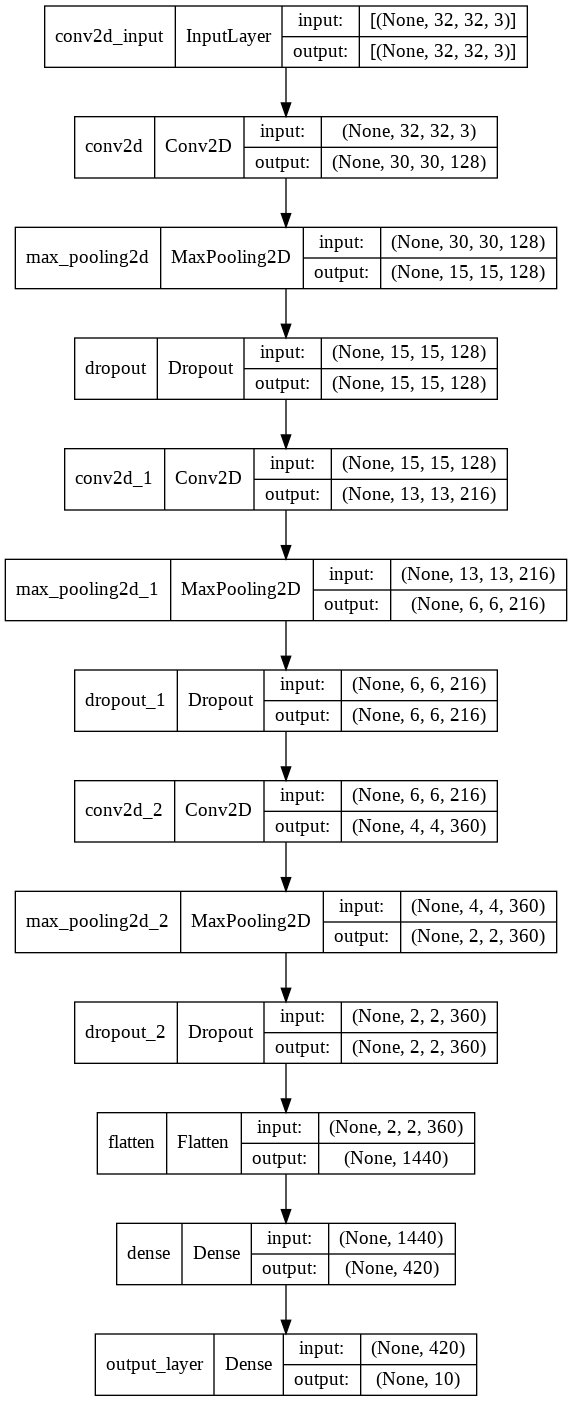

In [ ]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

### Compiling the model

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## Training the model

In [ ]:
start = time.time()

history = model.fit(train_images_norm
                    ,train_labels_split
                    ,epochs=50
                    ,batch_size=500
                    ,validation_data=(valid_images_norm, valid_labels_split)
                   ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)],
                   )

print("Total time: ", time.time() - start, "seconds")

Epoch 1/50
90/90 [==============================] - 13s 39ms/step - loss: 2.1816 - accuracy: 0.2827 - val_loss: 1.7279 - val_accuracy: 0.4012
Epoch 2/50
90/90 [==============================] - 3s 34ms/step - loss: 1.6029 - accuracy: 0.4517 - val_loss: 1.4508 - val_accuracy: 0.5038
Epoch 3/50
90/90 [==============================] - 3s 33ms/step - loss: 1.3948 - accuracy: 0.5255 - val_loss: 1.3037 - val_accuracy: 0.5580
Epoch 4/50
90/90 [==============================] - 3s 33ms/step - loss: 1.2780 - accuracy: 0.5715 - val_loss: 1.1596 - val_accuracy: 0.6124
Epoch 5/50
90/90 [==============================] - 3s 33ms/step - loss: 1.1722 - accuracy: 0.6086 - val_loss: 1.0852 - val_accuracy: 0.6302
Epoch 6/50
90/90 [==============================] - 3s 33ms/step - loss: 1.1085 - accuracy: 0.6332 - val_loss: 1.0173 - val_accuracy: 0.6636
Epoch 7/50
90/90 [==============================] - 3s 33ms/step - loss: 1.0560 - accuracy: 0.6497 - val_loss: 1.0061 - val_accuracy: 0.6734
Epoch 8/50
9

## Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy)

313/313 [==============================] - 1s 4ms/step - loss: 0.6864 - accuracy: 0.7956
test set accuracy:  0.7955999970436096


## Plotting Performance Metrics 

Matplotlib is used to create 2 plots -- displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

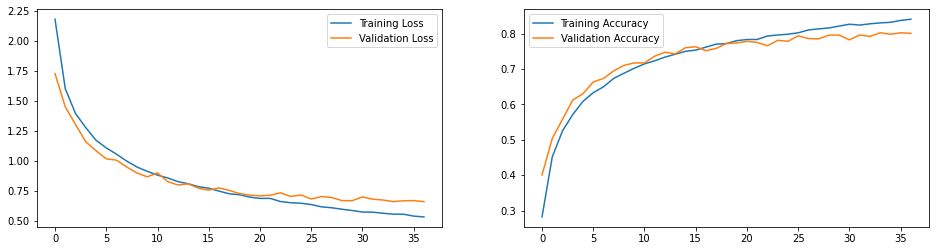

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Confusion matrices
Using `sklearn.metrics`, visualize the confusion matrix.

In [ ]:
pred1= model.predict(test_images_norm)
pred1 = np.argmax(pred1, axis=1)

In [ ]:
conf_mx = confusion_matrix(test_labels, pred1)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

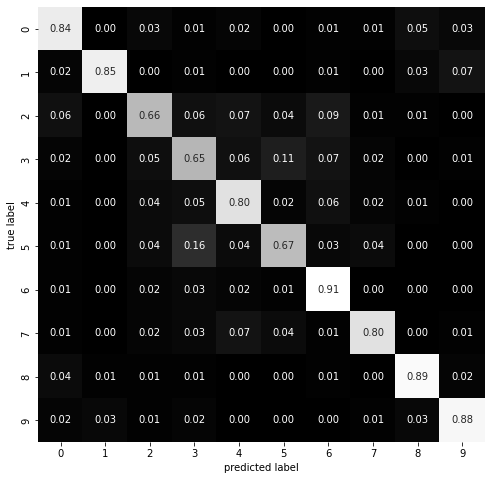

In [ ]:
plot_confusion_matrix(norm_conf_mx)

## Visualize predictions

In [ ]:
preds = model.predict(test_images_norm)
preds.shape

(10000, 10)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm) 

##Plot TSNE plot

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(valid_images_norm[:5000])
dense_layer_activations = activations[-2]
output_layer_activations = activations[-1]

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.768s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.096052
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.584763
[t-SNE] KL divergence after 300 iterations: 2.273604


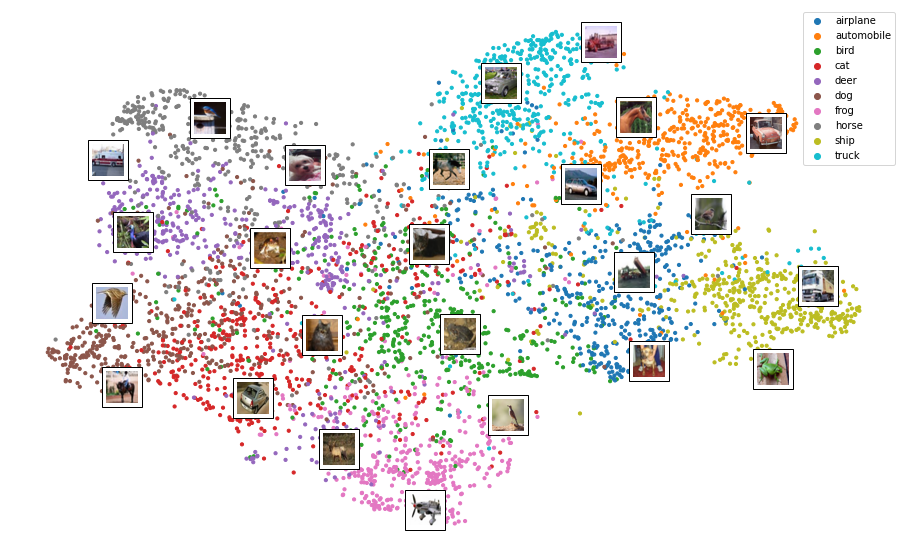

In [ ]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=valid_labels_split[:5000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(train_images[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

#Experiment 10
CNN with 4 convolution and 2 max pooling layers with regularization (batch normalization, L2 regulariazation, dropout, early stopping)

## Create the Model

### Build CNN Model

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3))) 
model.add(layers.Conv2D(filters=108, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D((2, 2),strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters=180, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.Conv2D(filters=210, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=260, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(layers.Dense(units=10, activation=tf.nn.softmax, name="output_layer"))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 108)       62316     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 108)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 108)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 180)       175140    
                                                                 
 conv2d_9 (Conv2D)           (None, 10, 10, 210)       340410    
                                                      

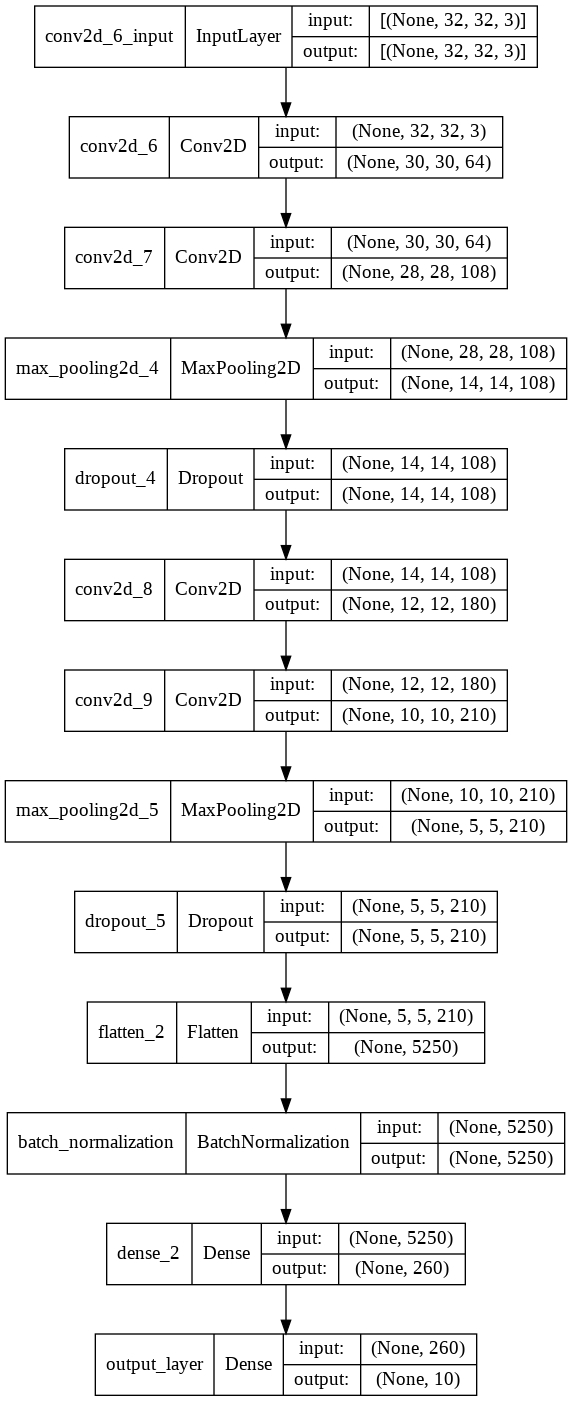

In [ ]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

### Compiling the model

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## Training the model

In [ ]:
start = time.time()

history = model.fit(train_images_norm
                    ,train_labels_split
                    ,epochs=30
                    ,batch_size=500
                    ,validation_data=(valid_images_norm, valid_labels_split)
                   ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)],
                   )

print("Total time: ", time.time() - start, "seconds")

Epoch 1/30
90/90 [==============================] - 5s 48ms/step - loss: 1.8255 - accuracy: 0.4747 - val_loss: 2.4163 - val_accuracy: 0.4020
Epoch 2/30
90/90 [==============================] - 4s 47ms/step - loss: 1.2198 - accuracy: 0.6459 - val_loss: 2.1539 - val_accuracy: 0.5722
Epoch 3/30
90/90 [==============================] - 4s 48ms/step - loss: 0.9742 - accuracy: 0.7161 - val_loss: 1.8217 - val_accuracy: 0.6324
Epoch 4/30
90/90 [==============================] - 4s 45ms/step - loss: 0.8483 - accuracy: 0.7549 - val_loss: 1.4376 - val_accuracy: 0.7042
Epoch 5/30
90/90 [==============================] - 4s 46ms/step - loss: 0.7587 - accuracy: 0.7849 - val_loss: 1.0312 - val_accuracy: 0.7586
Epoch 6/30
90/90 [==============================] - 4s 46ms/step - loss: 0.6965 - accuracy: 0.8109 - val_loss: 0.8290 - val_accuracy: 0.7820
Epoch 7/30
90/90 [==============================] - 4s 46ms/step - loss: 0.6424 - accuracy: 0.8289 - val_loss: 0.8656 - val_accuracy: 0.7516
Epoch 8/30
90

## Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.8356 - accuracy: 0.7946
test set accuracy:  0.7946000099182129


## Plotting Performance Metrics 

Matplotlib is used to create 2 plots -- displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

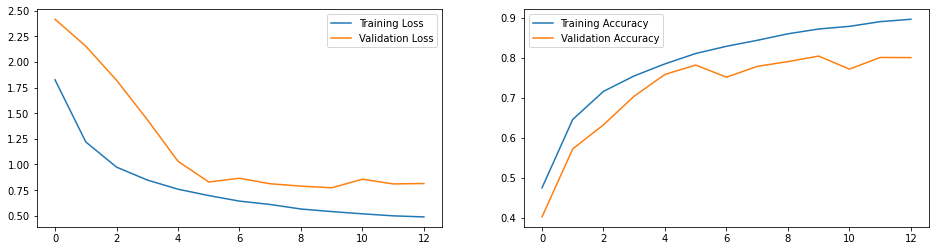

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Confusion matrices
Using `sklearn.metrics`, visualize the confusion matrix.

In [ ]:
pred1= model.predict(test_images_norm)
pred1 = np.argmax(pred1, axis=1)

In [ ]:
conf_mx = confusion_matrix(test_labels, pred1)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

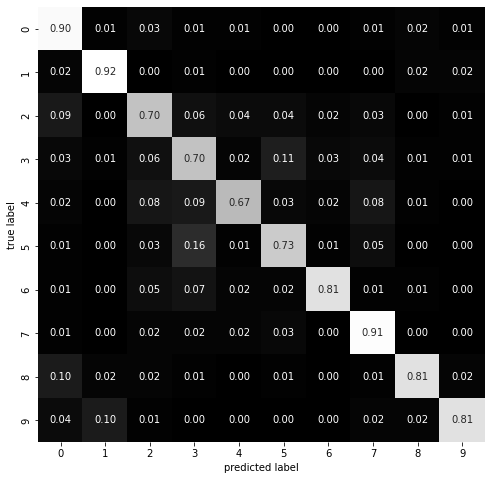

In [ ]:
plot_confusion_matrix(norm_conf_mx)

## Visualize predictions

In [ ]:
preds = model.predict(test_images_norm)
preds.shape

(10000, 10)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm) 

##Plot TSNE plot

In [ ]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(valid_images_norm[:5000])
dense_layer_activations = activations[-2]
output_layer_activations = activations[-1]

In [ ]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.620s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 4.241502
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.231979
[t-SNE] KL divergence after 300 iterations: 2.674195


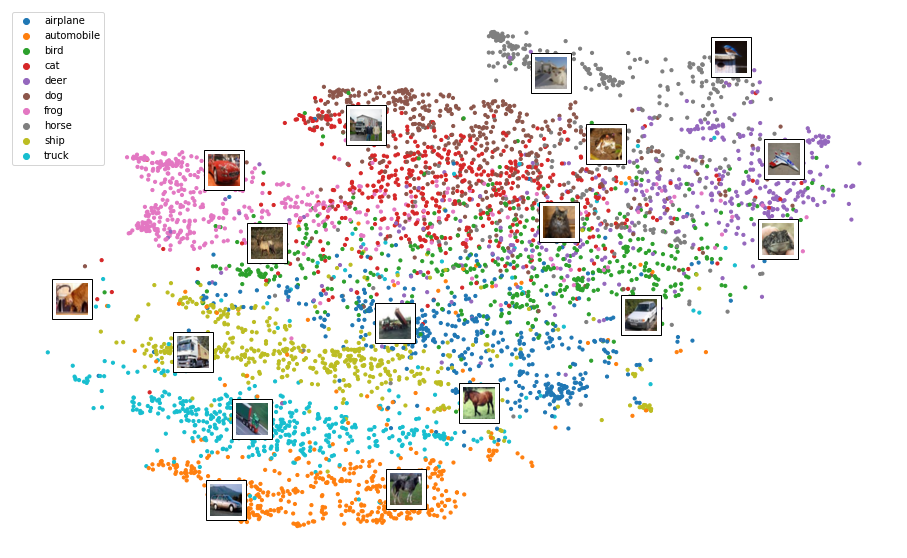

In [ ]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=valid_labels_split[:5000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(train_images[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()